# MCM-C题——机器学习部分Cluster3
## 一、数据导入
##### 导入库

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(font_scale=1)
pd.set_option('display.max_columns', 0) # 显示所有列
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, precision_recall_curve, roc_curve, auc
from PIL import Image

##### 导入数据

In [2]:
# 导入数据
df = pd.read_csv("cluster3.csv",index_col=0)
y = df["Medal"]
X = df.iloc[:, :-1]

# 随机打乱数据
data_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
x = data_shuffled.iloc[:, :-1]
y = data_shuffled.iloc[:, -1]

# 划分
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)


total_count = len(y_train)
all_values = [0, 1, 2, 3]
counter = Counter(y_train)
for value in all_values:
    count = counter[value]
    ratio = count / total_count if total_count > 0 else 0
counts = y_train.value_counts(normalize=True) # normalize=True 返回比例

smote = SMOTE(sampling_strategy='auto')  # 默认策略
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# 查看采样后分布
print(Counter(y_train_resampled))

x_train_resampled['Medal'] = y_train_resampled

## 数据准备
X_train = x_train_resampled.drop('Medal', axis=1)
y_train = x_train_resampled['Medal']
X_test = x_test
y_test = y_test

Counter({0: 47986, 3: 47986, 1: 47986, 2: 47986})


##### 定义函数

In [3]:
## 函数定义
def model_eval(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    #print(accuracy)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    #print(cnf_matrix)
    #metrics.plot_confusion_matrix(model, X_test, y_test)
    #plt.show()
    return accuracy, cnf_matrix

def cross_val (model, x, y, folds):
    crossvalidation = cross_val_score(model, x, y, cv= folds, n_jobs=-1)
    return crossvalidation

def store_results(name, ytrain, xtrain, ytest, xtest, model, folds):
    
    crossvalidation = cross_val(model, xtrain, ytrain, folds)
    
    accuracy_test, cm1 =  model_eval(model, xtrain, ytrain)
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    recall_test = TP / (TP+FP)
    precision_test = TP / (TP+FN)
    
    accuracy_train, cm1 =  model_eval(model, xtest, ytest)
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    recall_train = TP / (TP+FP)
    precision_train = TP / (TP+FN)

    entry = {'Model': [name],
          'Accuracy_train': [accuracy_train],
          'recall_train': [recall_train],
          'precision_train': [precision_train],
          'Accuracy_test': [accuracy_train],
          'recall_test': [recall_train],
          'precision_test': [precision_train],
          'CrossVal_Mean': [crossvalidation.mean()],           
          'CrossVal1': [crossvalidation[0]],
          'CrossVal2': [crossvalidation[1]],
          'CrossVal3': [crossvalidation[2]],
          'CrossVal4': [crossvalidation[3]],
          'CrossVal5': [crossvalidation[4]],
          }
    result = pd.DataFrame(entry)
    return result
outcome = pd.DataFrame()

## 二、模型
### 2.1 Dummy Classifier
##### 混淆矩阵

预测准确率: 0.864378808395396


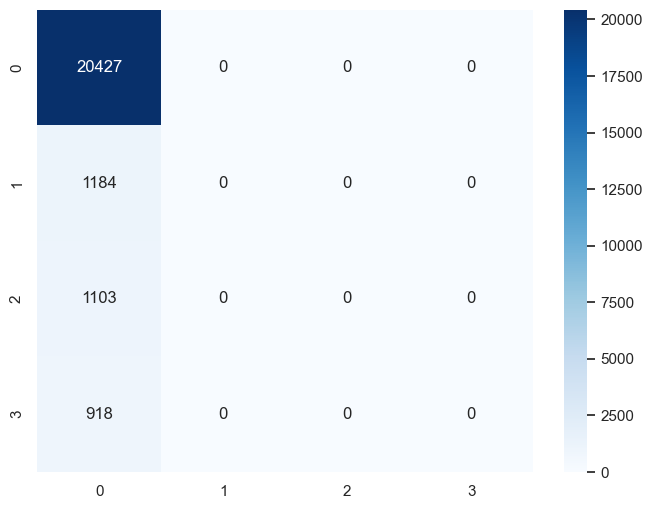

In [4]:
## 1、Dummy Classifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

accuracy, cnf_matrix = model_eval(dummy, X_test, y_test)
print("预测准确率:", accuracy)

# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="Dummy classifier混淆矩阵.png")

##### 模型评估

In [5]:
temp = store_results("Dummy classifier", y_train, X_train, y_test, X_test, dummy, 5)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.864379,NaN,0.0,0.864379,NaN,0.0,0.249995,0.249993,0.249993,0.249993,0.249993,0.25


##### ROC&AUC

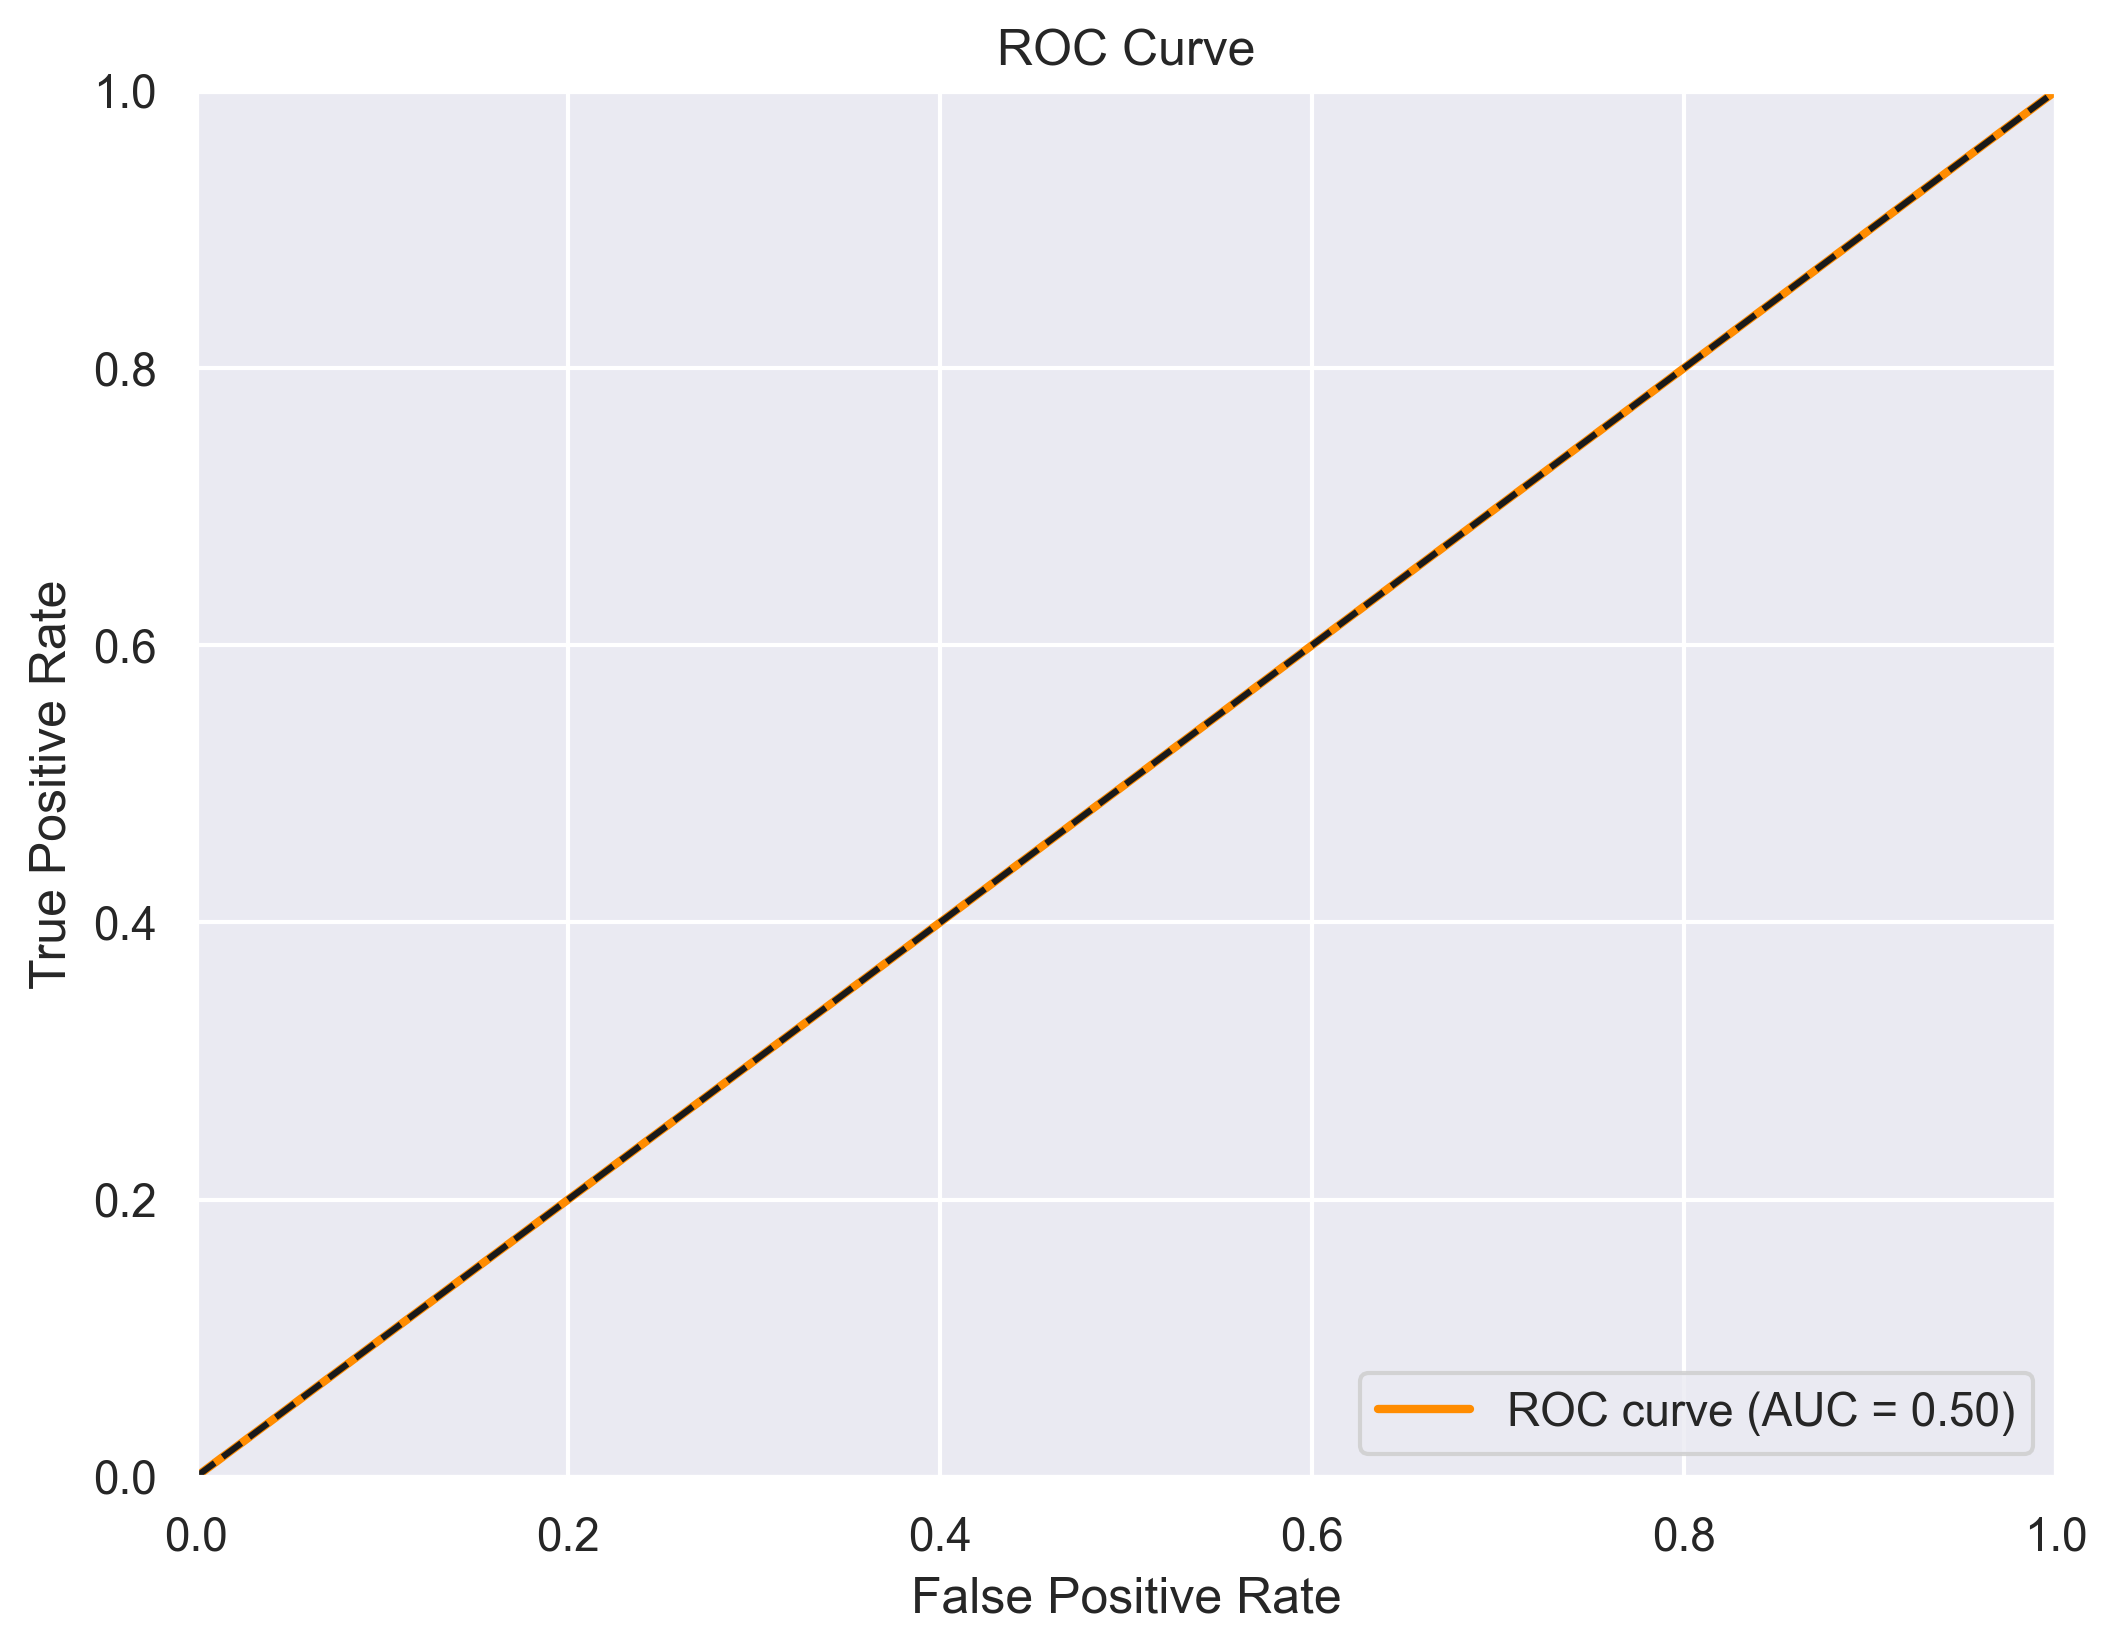

In [6]:
y_pred = dummy.predict(X_test)

# ROC曲线&AUC值
fpr_dummy, tpr_dummy, thresholds = roc_curve(y_test, y_pred, pos_label=1)
auc_dummy = auc(fpr_dummy, tpr_dummy)

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr_dummy, tpr_dummy, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_dummy)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig(fname="Dummy classifier_ROC曲线.png")

### 2.2 Logistic
##### 调参和混淆矩阵
后续同理

最佳参数: {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}
预测准确率: 0.7868144888287069


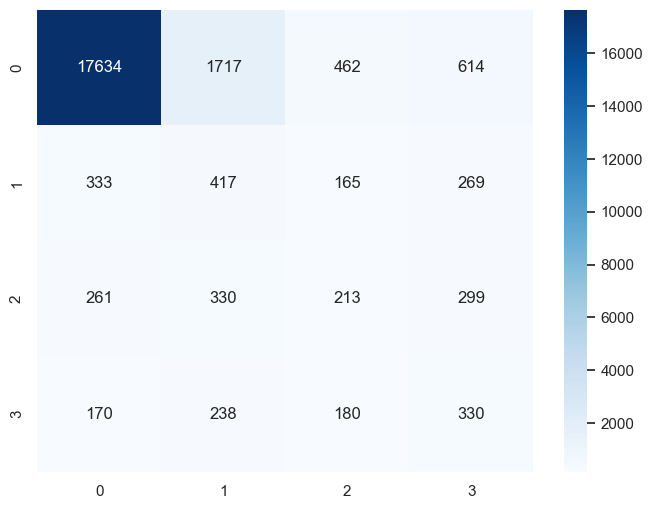

In [7]:
## 2、Logistic
# 网格搜索
param_grid = {
    'C': [0.001],
    'penalty': ['l1'],
    'solver': ['saga'] 
}

# 网格搜索
grid_search = GridSearchCV(
    estimator=LogisticRegression(max_iter=5000),
    param_grid=param_grid,
    cv=5,  # 5 折交叉验证
    scoring='accuracy',
    return_train_score=True,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)
print("最佳参数:", grid_search.best_params_)

# 最优模型拟合
Logistic_model = grid_search.best_estimator_
Logistic_model.fit(X_train, y_train)

# 模型预测
y_pred = Logistic_model.predict(X_test)
accuracy, cnf_matrix = model_eval(Logistic_model, X_test, y_test)
print("预测准确率:", accuracy)

# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="Logistic混淆矩阵.png")

##### 模型评估
后续同理

In [8]:
temp = store_results("logistic", y_train, X_train, y_test, X_test, Logistic_model, 5)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.864379,NaN,0.000,0.864379,NaN,0.000,0.249995,0.249993,0.249993,0.249993,0.249993,0.250000
1,logistic,0.786814,0.195408,0.556,0.786814,0.195408,0.556,0.443812,0.446013,0.444763,0.444711,0.440334,0.443237


##### ROC&AUC
后续同理

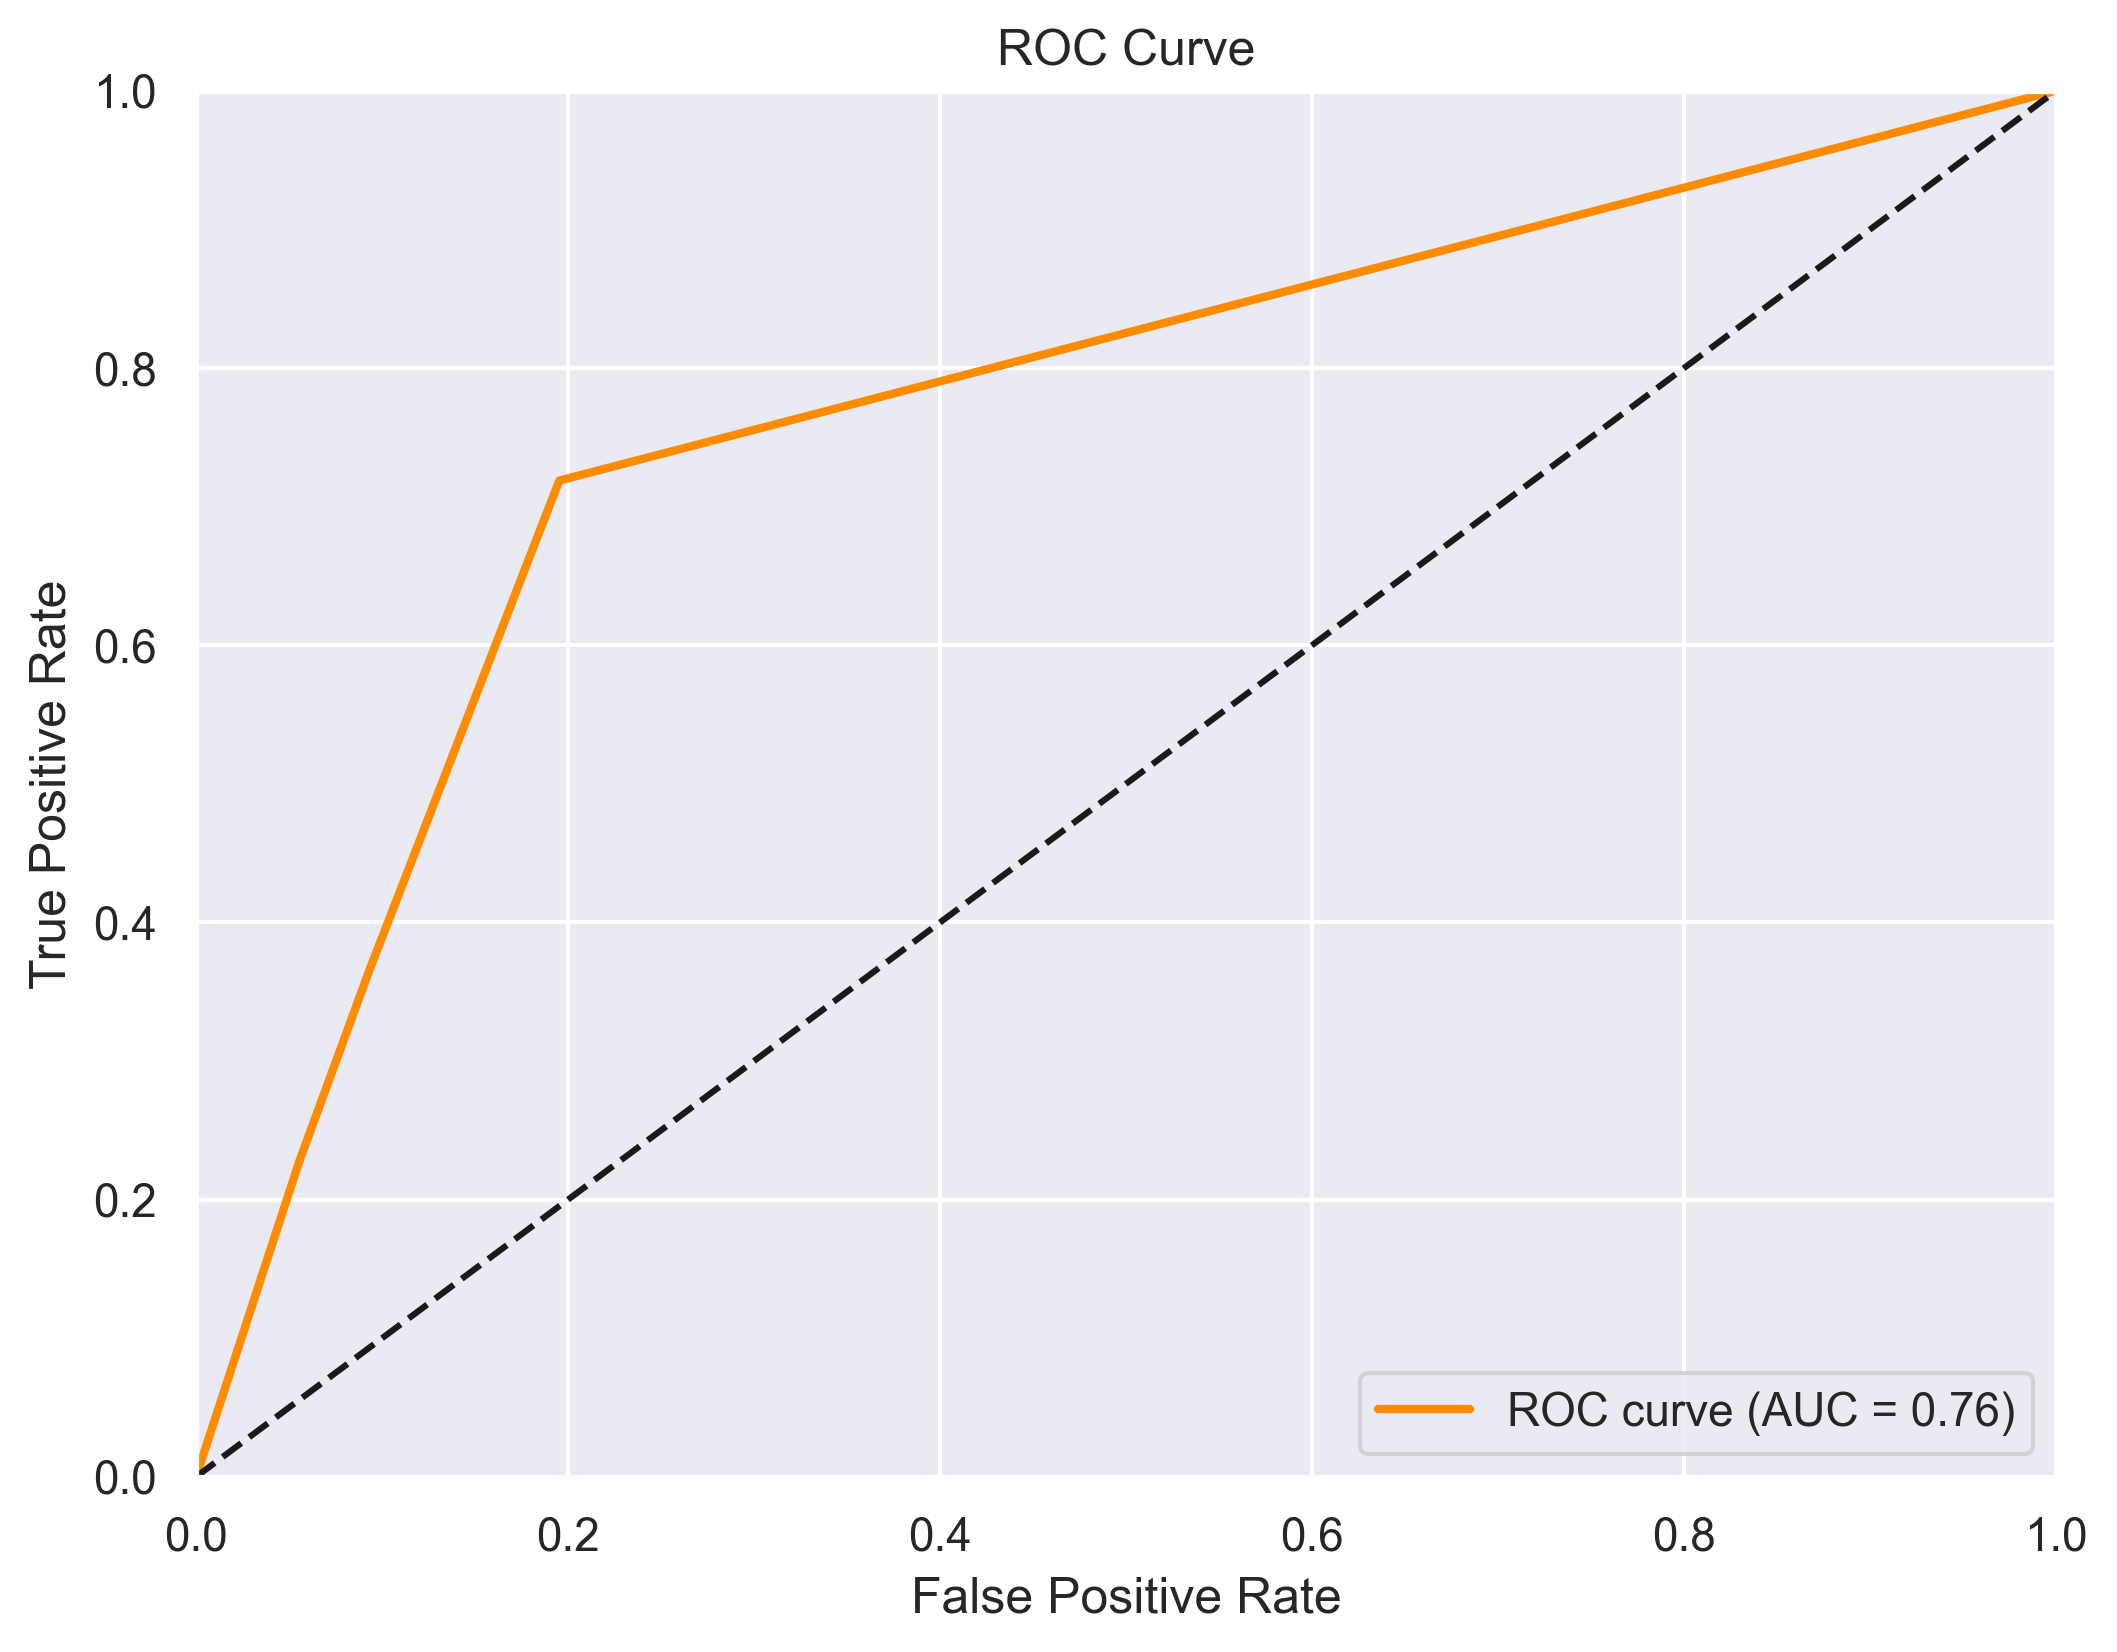

In [9]:
##  ROC曲线&AUC值
fpr_logistic, tpr_logistic, thresholds = roc_curve(y_test, y_pred, pos_label=1)
auc_logistic = auc(fpr_logistic, tpr_logistic)

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr_logistic, tpr_logistic, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_logistic)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig(fname="Logistic_ROC曲线.png")

### 2.3 Decision Tree

最佳参数: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 400}
预测准确率: 0.8268026404874746


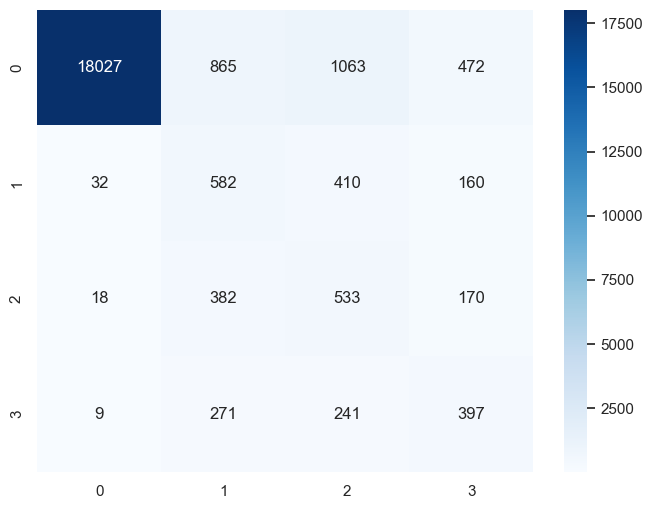

In [10]:
## 3、Decision Tree
# 调参
# 定义参数网格
param_grid = {
    'criterion': ['gini'],  # 不纯度度量
    'max_depth': [10],  # 最大深度
    'min_samples_split': [400],  # 内部节点再划分所需最小样本数
}

# 网格搜索
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=5,  # 5 折交叉验证
    scoring='accuracy',
    return_train_score=True,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)
print("最佳参数:", grid_search.best_params_)

# 最优模型拟合
dt_basic = grid_search.best_estimator_
dt_basic.fit(X_train, y_train)

# 模型预测
y_preds = dt_basic.predict(X_test)
accuracy, cnf_matrix = model_eval(dt_basic, X_test, y_test)
print("预测准确率:", accuracy)

# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="决策树混淆矩阵.png")

In [11]:
temp = store_results("决策树", y_train, X_train, y_test, X_test, dt_basic, 5)
outcome = pd.concat([outcome, temp], ignore_index=True)
print(outcome)

              Model  Accuracy_train  ...  CrossVal4  CrossVal5
0  Dummy classifier        0.864379  ...   0.249993   0.250000
1          logistic        0.786814  ...   0.440334   0.443237
2               决策树        0.826803  ...   0.632134   0.636032

[3 rows x 13 columns]


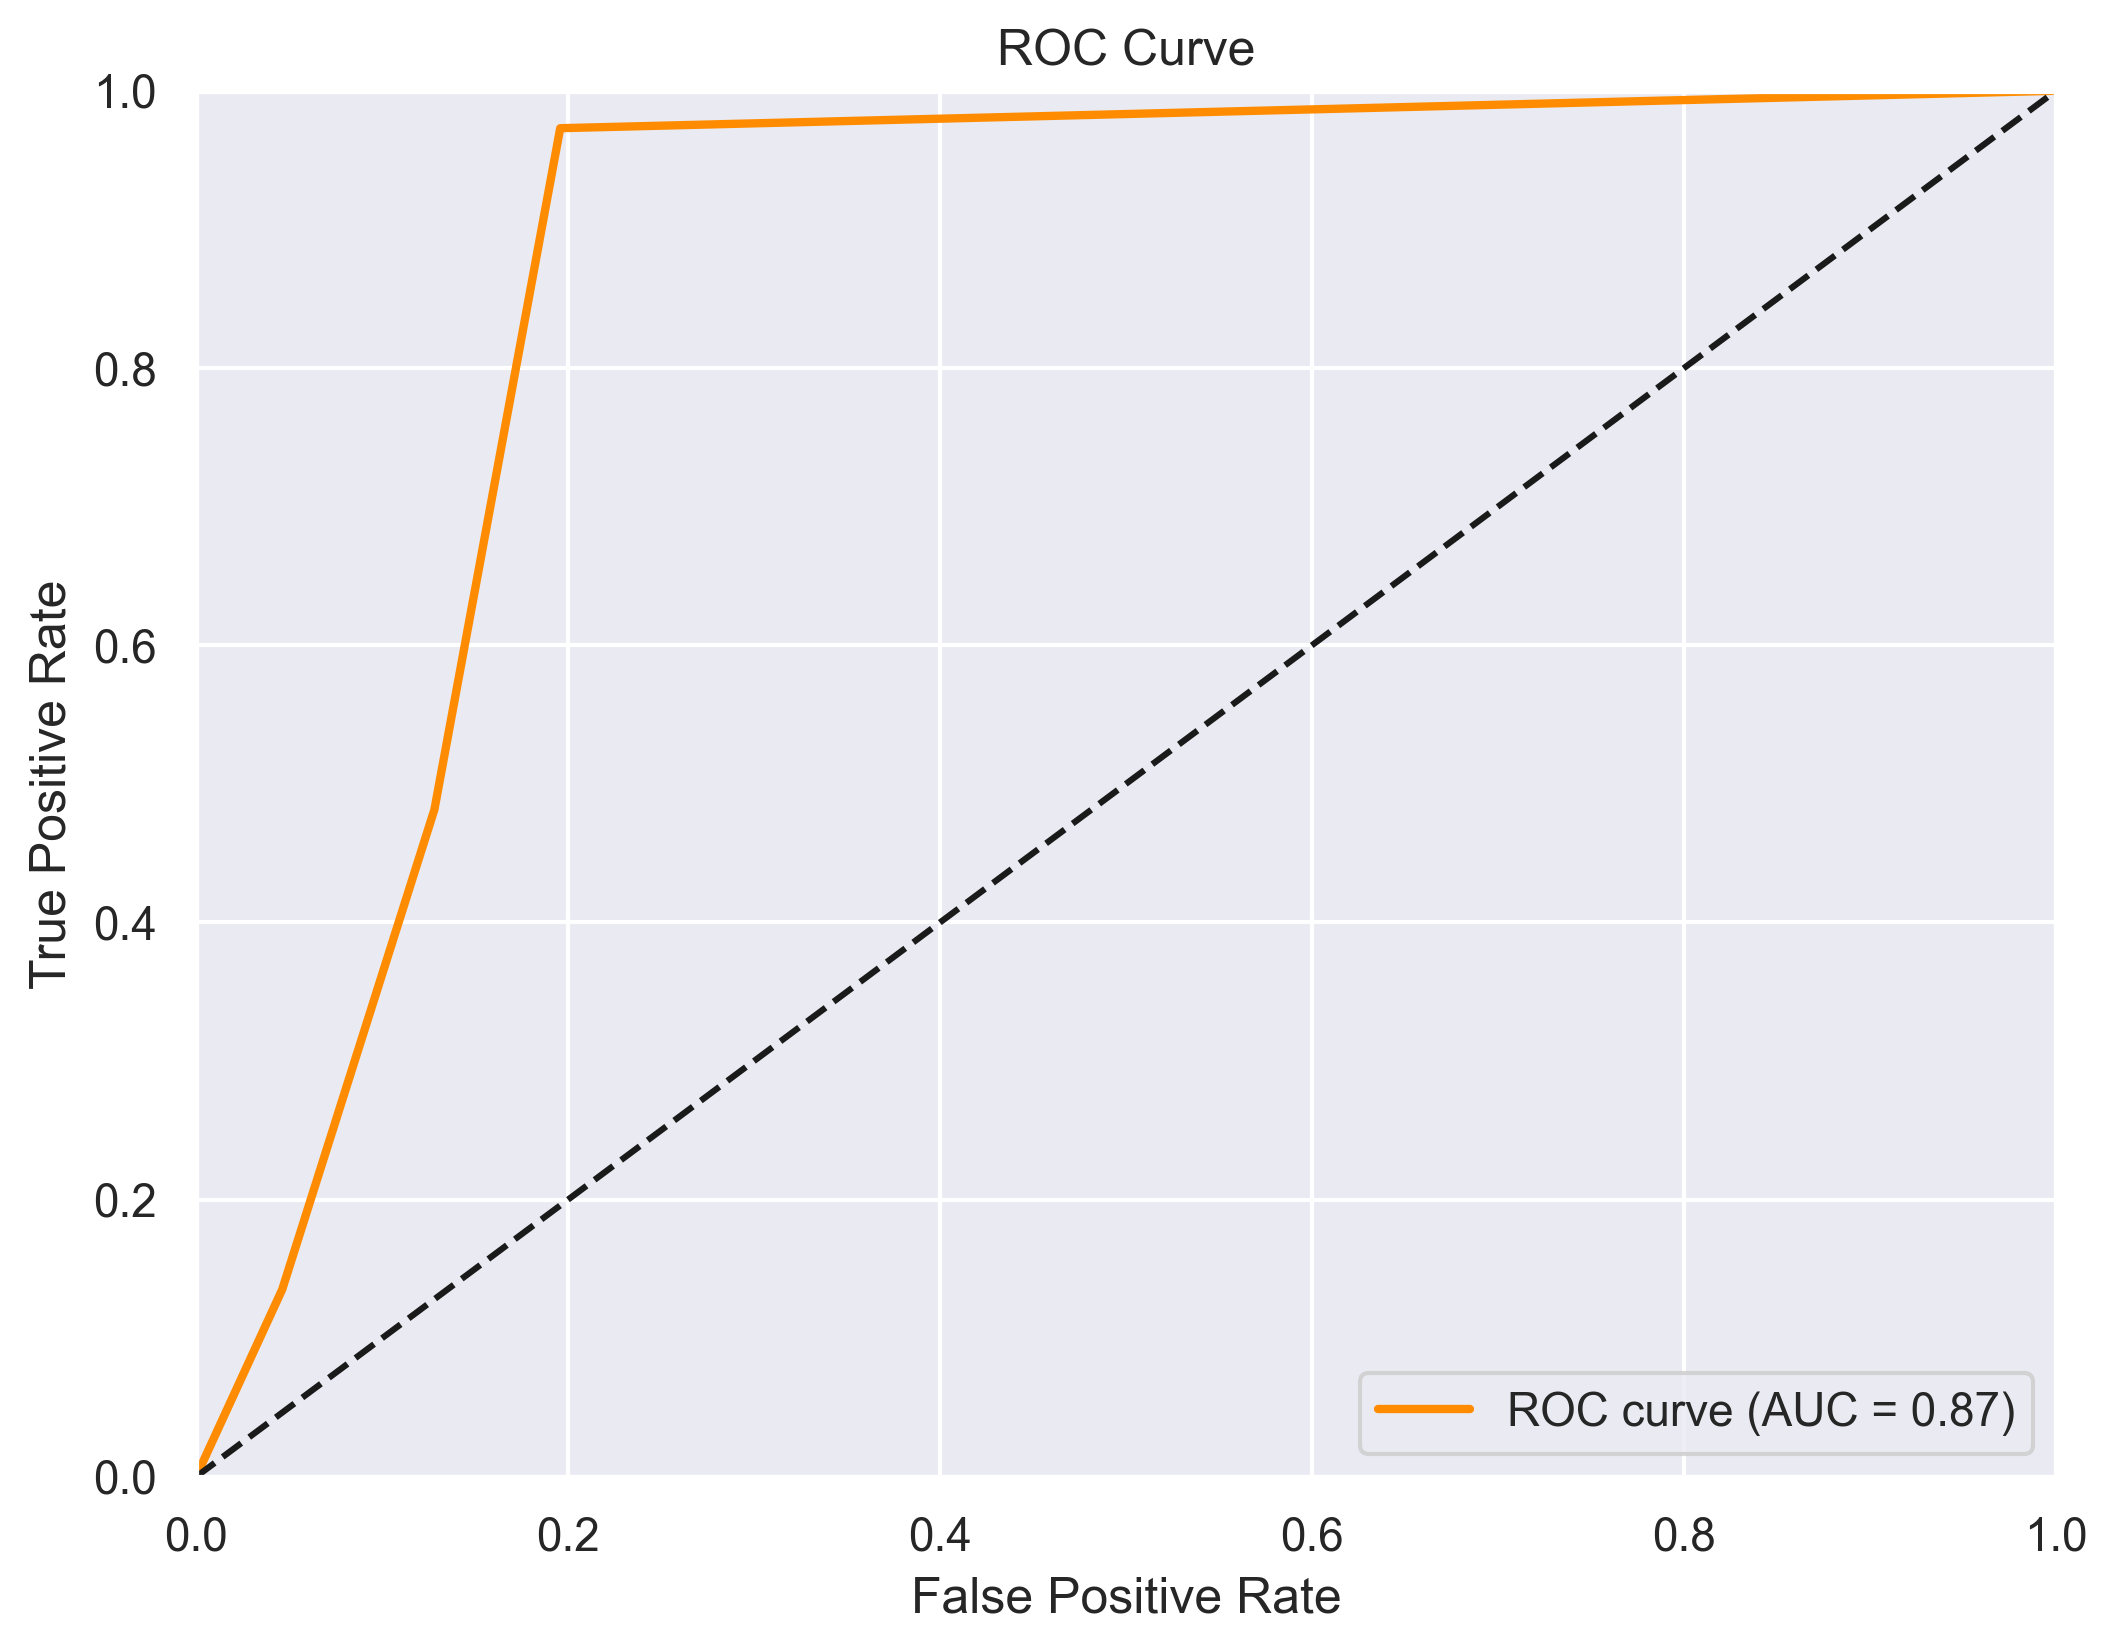

In [12]:
# ROC曲线&AUC值
fpr_dt, tpr_dt, thresholds = roc_curve(y_test, y_preds, pos_label=1)
auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_dt)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig(fname="决策树_ROC曲线.png")

### 2.4 SVM

In [13]:
# ## 4、SVM
# # 模型拟合
# best_model_svm = SVC()
# best_model_svm.fit(X_train, y_train)
# # 使用最佳模型进行预测和评估
# y_best_pred_svm = best_model_svm.predict(X_test)

# # 计算准确率Accuracy
# accuracy_svm = accuracy_score(y_test, y_best_pred_svm)
# print("SVM模型预测准确率:", accuracy_svm)

# # 精确率precision、召回率recall、F1值f1score等
# print(classification_report(y_test, y_best_pred_svm))

# # 混淆矩阵
# conf_matrix_svm = confusion_matrix(y_test, y_best_pred_svm)

# # 使用seaborn绘制混淆矩阵热图
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues")
# plt.savefig(fname="SVM混淆矩阵.png")

In [14]:
# temp = store_results("SVM", y_train, X_train, y_test, X_test, best_model_svm, 5)
# outcome = pd.concat([outcome, temp], ignore_index=True)
# outcome

In [15]:
# # ROC曲线&AUC值
# fpr_svm, tpr_svm, thresholds = roc_curve(y_test, y_best_pred_svm, pos_label=1)
# auc_svm = auc(fpr_svm, tpr_svm)

# plt.figure(figsize=(8, 6), dpi=300)
# plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_svm)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc="lower right")
# plt.savefig(fname="SVM_ROC曲线.png")

### 2.5 KNN

KNN最佳参数: {}
KNN最佳得分: 0.9032478353267731
KNN模型预测准确率: 0.803486797562627
              precision    recall  f1-score   support

           0       0.96      0.82      0.89     20427
           1       0.32      0.66      0.43      1184
           2       0.37      0.68      0.48      1103
           3       0.37      0.69      0.48       918

    accuracy                           0.80     23632
   macro avg       0.51      0.71      0.57     23632
weighted avg       0.88      0.80      0.83     23632



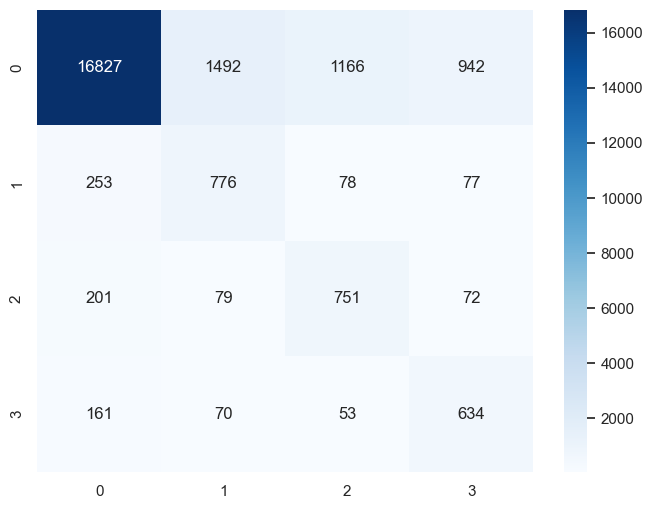

In [16]:
## 5、KNN
# 网格搜索
param_grid = {
}

# 创建KNN分类器模型实例
knn_model = KNeighborsClassifier()

# 创建网格搜索对象
grid_search_knn = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    scoring='accuracy',  # 使用准确率作为评估指标
    cv=5,  # 5折交叉验证
    n_jobs=-1  # 使用所有可用的CPU核心进行并行计算
)

# 在训练数据上执行网格搜索
grid_search_knn.fit(X_train, y_train)

# 获取最佳参数
best_params_knn = grid_search_knn.best_params_
print("KNN最佳参数:", best_params_knn)

# 获取最佳模型
best_model_knn = grid_search_knn.best_estimator_

# 获取最佳得分（在交叉验证集上的平均准确率）
best_score_knn = grid_search_knn.best_score_
print("KNN最佳得分:", best_score_knn)

# 使用最佳模型进行预测和评估
y_best_pred_knn = best_model_knn.predict(X_test)

# 计算准确率Accuracy
accuracy_knn = accuracy_score(y_test, y_best_pred_knn)
print("KNN模型预测准确率:", accuracy_knn)

# 精确率precision、召回率recall、F1值f1score等
print(classification_report(y_test, y_best_pred_knn))

# 混淆矩阵
conf_matrix_knn = confusion_matrix(y_test, y_best_pred_knn)

# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="KNN混淆矩阵.png")

In [17]:
temp = store_results("KNN", y_train, X_train, y_test, X_test, best_model_knn, 5)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.864379,NaN,0.000000,0.864379,NaN,0.000000,0.249995,0.249993,0.249993,0.249993,0.249993,0.250000
1,logistic,0.786814,0.195408,0.556000,0.786814,0.195408,0.556000,0.443812,0.446013,0.444763,0.444711,0.440334,0.443237
2,决策树,0.826803,0.402211,0.947883,0.826803,0.402211,0.947883,0.632653,0.633306,0.634192,0.627602,0.632134,0.636032
3,KNN,0.803487,0.342152,0.754130,0.803487,0.342152,0.754130,0.903248,0.903045,0.902081,0.901013,0.904348,0.905752


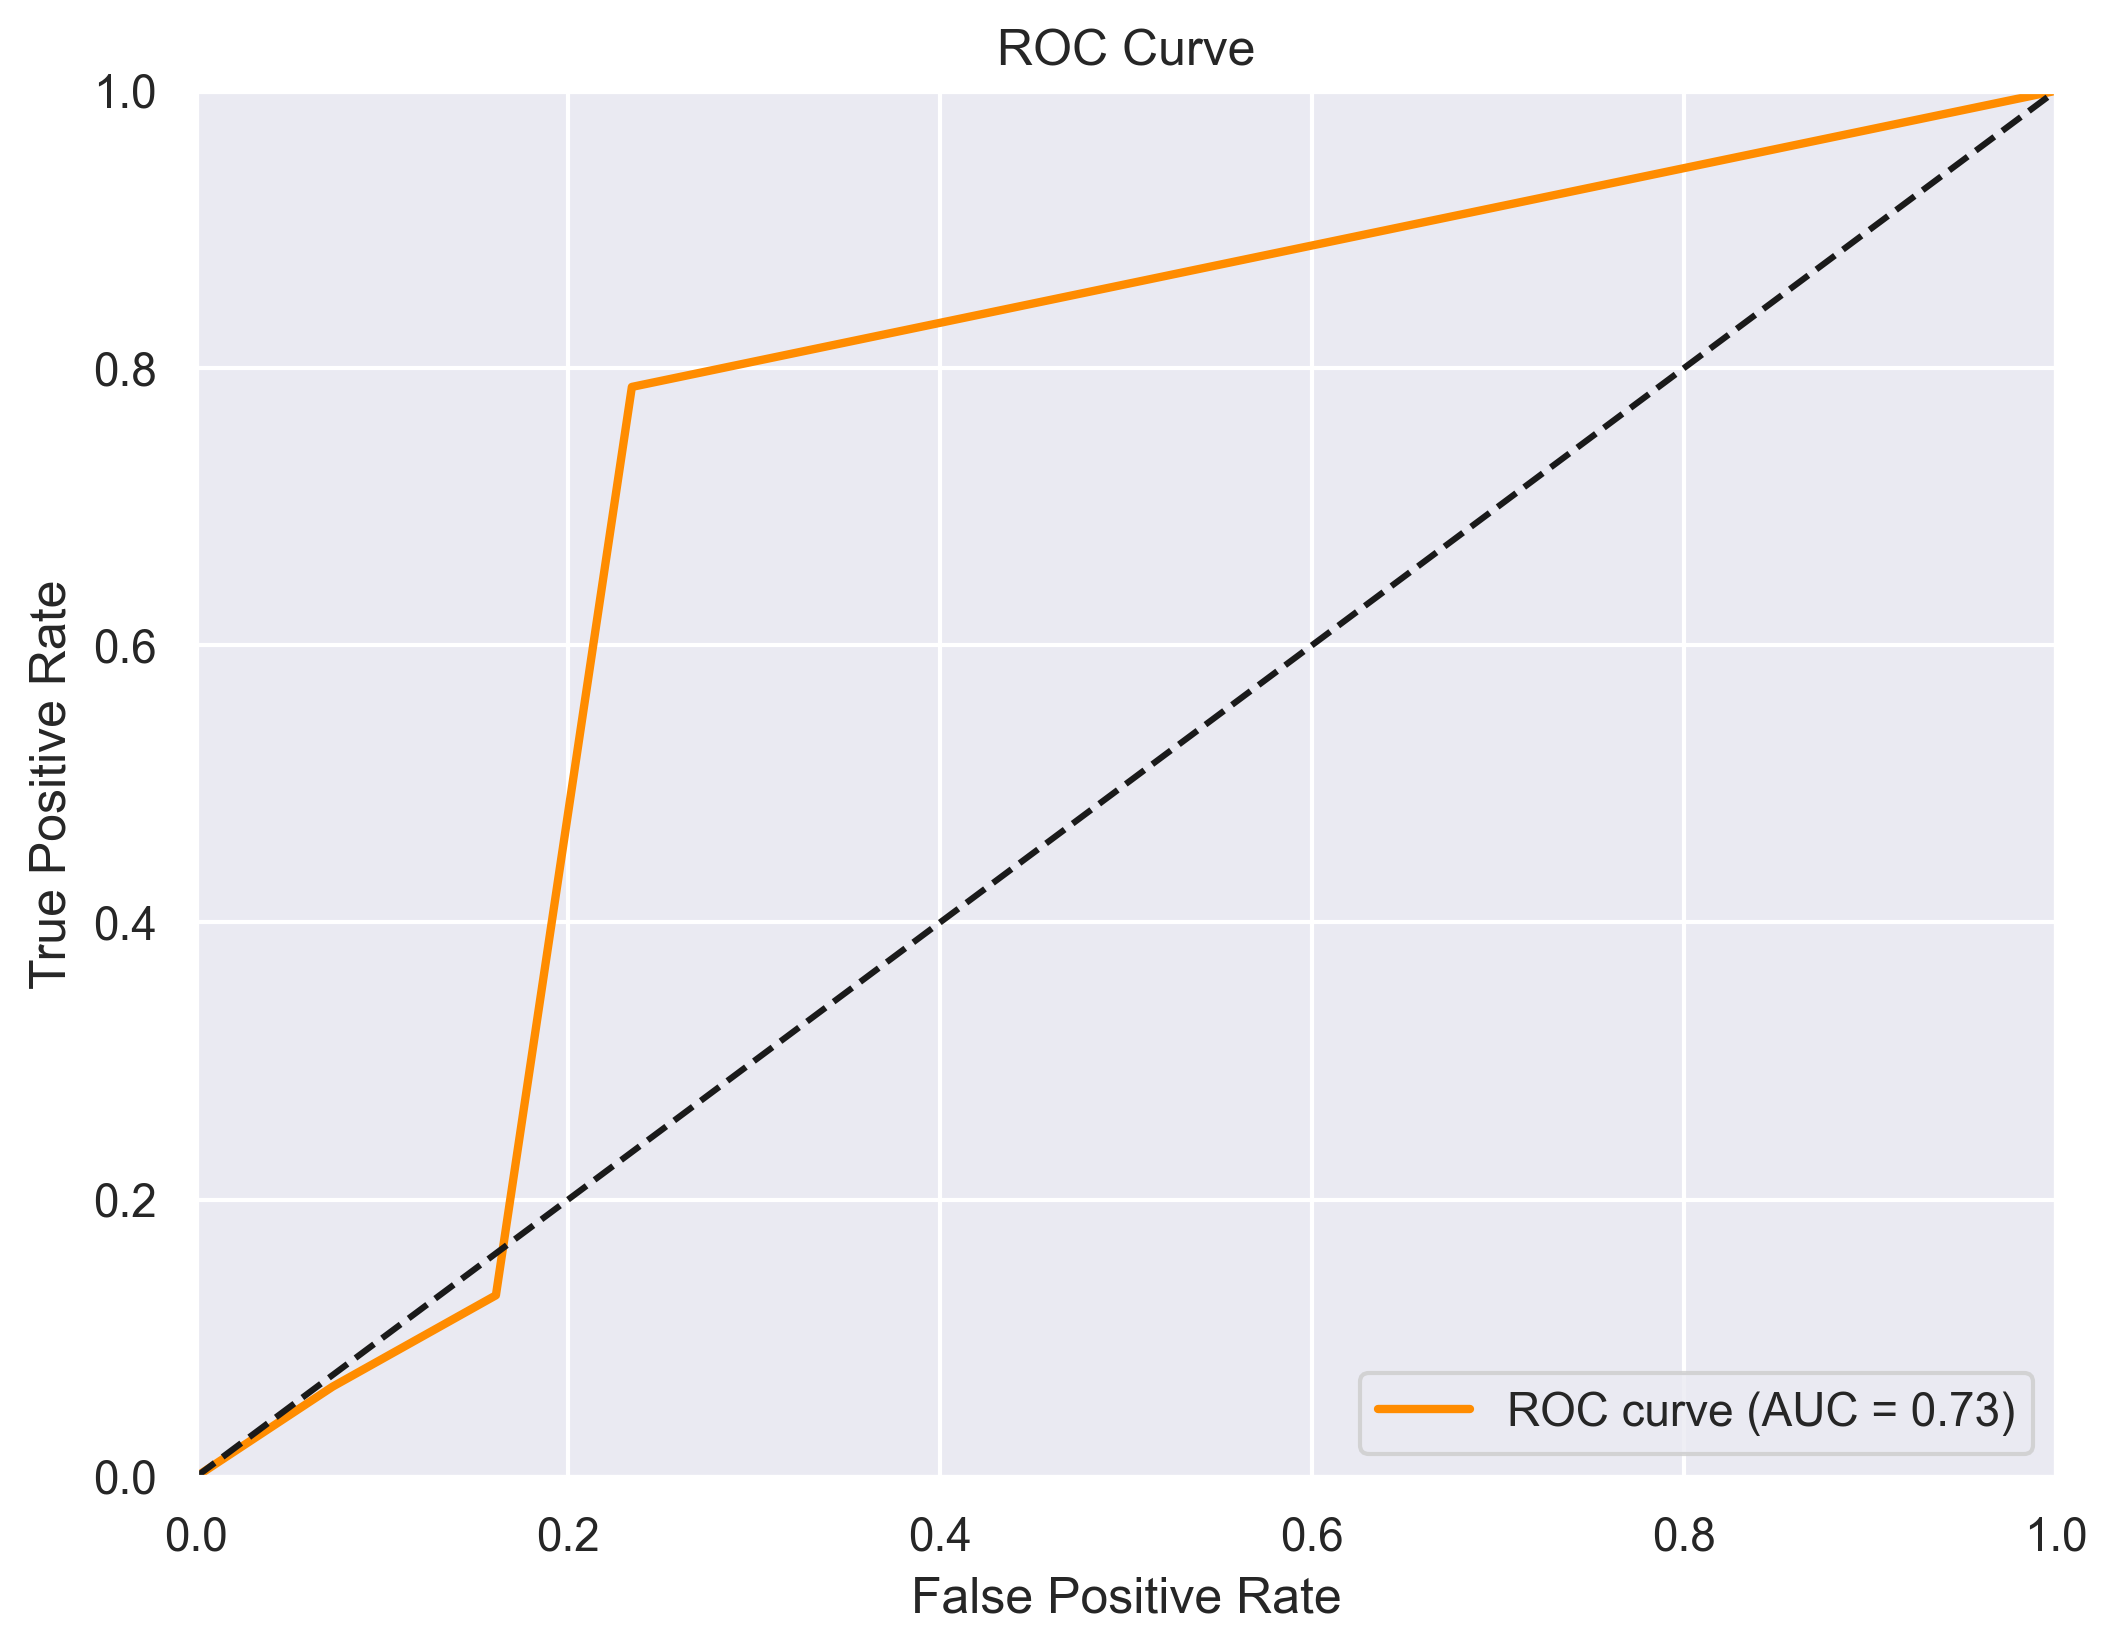

In [18]:
# ROC曲线&AUC值
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, y_best_pred_knn, pos_label=1)
auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_knn)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig(fname="KNN_ROC曲线.png")

### 2.6 Adaboost-Logistic

In [ ]:
# ## 6、Adaboost-Logistic
# # 建立AdaBoost分类器，基学习器为LogisticRegression
# # 网格搜索
# # 定义参数网格
# param_grid = {
#     'n_estimators': [50],  # 尝试不同的弱学习器数量
#     'learning_rate': [0.1],  # 不同的学习率
#     'estimator__C': [0.1],  # 不同的正则化系数
# }

# base_estimator = LogisticRegression(penalty='l1', C=0.001, solver='saga', max_iter=5000)
# model = AdaBoostClassifier(estimator=base_estimator, algorithm='SAMME')

# # 网格搜索
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring='accuracy',  # 使用准确率作为评估指标
#     cv=5,  # 5折交叉验证
#     n_jobs=-1  # 使用所有可用的CPU核心进行并行计算
# )

# grid_search.fit(X_train, y_train)

# # 获取最佳参数
# best_params = grid_search.best_params_
# print("最佳参数:", best_params)

# # 获取最佳模型
# best_model = grid_search.best_estimator_

# # 获取最佳得分（在交叉验证集上的平均准确率）
# best_score = grid_search.best_score_
# print("最佳得分:", best_score)

# ## 预测
# y_best_pred = best_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_best_pred)
# print("Adaboost-Logistic:", accuracy)
# print(classification_report(y_test, y_best_pred))

# # 混淆矩阵
# conf_matrix = confusion_matrix(y_test, y_best_pred)

# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
# plt.savefig(fname="Adaboost-Logistic混淆矩阵.png")

In [ ]:
# temp = store_results("Adaboost-Logistic", y_train, X_train, y_test, X_test, best_model, 5)
# outcome = pd.concat([outcome, temp], ignore_index=True)
# outcome

In [ ]:
# ##  ROC曲线&AUC值
# fpr_adaboost, tpr_adaboost, thresholds = roc_curve(y_test, y_best_pred, pos_label=1)
# auc = auc(fpr_adaboost, tpr_adaboost)

# plt.figure(figsize=(8, 6), dpi=300)
# plt.plot(fpr_adaboost, tpr_adaboost, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc="lower right")
# plt.savefig(fname="Adaboost-Logistic_ROC曲线.png")

In [ ]:
# ## 模型对比
# plt.figure(figsize=(16, 12), dpi=300)
# plt.plot(fpr_dummy, tpr_dummy, lw=2, label='Dummy:ROC curve (AUC = %0.2f)' % auc_dummy)
# plt.plot(fpr_logistic, tpr_logistic, lw=2, label='Logistic:ROC curve (AUC = %0.2f)' % auc_logistic)
# plt.plot(fpr_dt, tpr_dt, lw=2, label='Decision Tree:ROC curve (AUC = %0.2f)' % auc_dt)
# plt.plot(fpr_knn, tpr_knn, lw=2, label='KNN:ROC curve (AUC = %0.2f)' % auc_knn)
# plt.plot(fpr_adaboost, tpr_adaboost, lw=2, label='Adaboost-Logistic:ROC curve (AUC = %0.2f)' % auc)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc="lower right")
# plt.savefig(fname="ROC曲线1.png")

### 2.7 XGBoost

XGBoost最佳参数: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
XGBoost最佳得分: 0.7881934233873181
XGBoost模型预测准确率: 0.8952268111035884
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     20427
           1       0.40      0.69      0.50      1184
           2       0.50      0.57      0.54      1103
           3       0.53      0.69      0.60       918

    accuracy                           0.90     23632
   macro avg       0.61      0.72      0.65     23632
weighted avg       0.93      0.90      0.91     23632



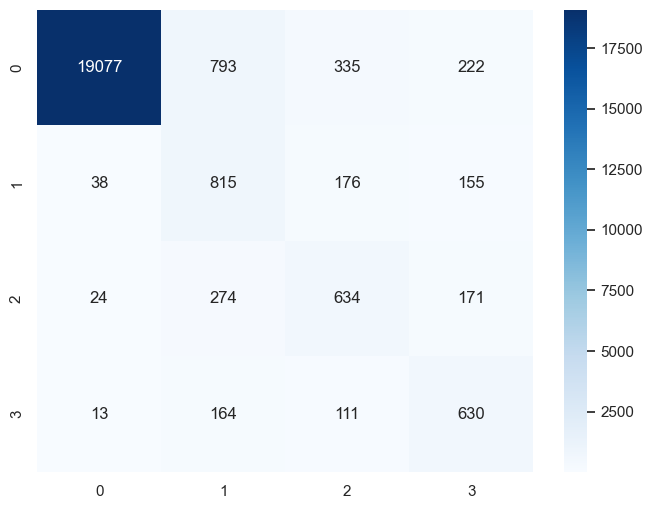

In [20]:
## 7、XGBoost
# 网格搜索
param_grid = {
    'n_estimators': [100, 150],  # 树的数量
    'learning_rate': [0.01, 0.1],  # 学习率
    'max_depth': [3, 5],  # 树的最大深度
    'gamma': [0, 0.1, 0.01]  # 用于控制是否后剪枝的参数，越大越保守，防止过拟合
}

# 创建XGBoost分类器模型实例，四分类
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, random_state=0)

# 创建网格搜索对象
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  # 使用准确率作为评估指标
    cv=5,  # 5折交叉验证
    n_jobs=-1  # 使用所有可用的CPU核心进行并行计算
)

# 在训练数据上执行网格搜索
grid_search_xgb.fit(X_train, y_train)

# 获取最佳参数
best_params_xgb = grid_search_xgb.best_params_
print("XGBoost最佳参数:", best_params_xgb)

# 获取最佳模型
best_model_xgb = grid_search_xgb.best_estimator_

# 获取最佳得分（在交叉验证集上的平均准确率）
best_score_xgb = grid_search_xgb.best_score_
print("XGBoost最佳得分:", best_score_xgb)

# 使用最佳模型进行预测和评估
y_best_pred_xgb = best_model_xgb.predict(X_test)

# 计算准确率Accuracy
accuracy_xgb = accuracy_score(y_test, y_best_pred_xgb)
print("XGBoost模型预测准确率:", accuracy_xgb)

# 精确率precision、召回率recall、F1值f1score等
print(classification_report(y_test, y_best_pred_xgb))

# 混淆矩阵
conf_matrix_xgb = confusion_matrix(y_test, y_best_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="XGBoost混淆矩阵.png")

In [21]:
temp = store_results("XGBoost", y_train, X_train, y_test, X_test, best_model_xgb, 5)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.864379,NaN,0.000000,0.864379,NaN,0.000000,0.249995,0.249993,0.249993,0.249993,0.249993,0.250000
1,logistic,0.786814,0.195408,0.556000,0.786814,0.195408,0.556000,0.443812,0.446013,0.444763,0.444711,0.440334,0.443237
2,决策树,0.826803,0.402211,0.947883,0.826803,0.402211,0.947883,0.632653,0.633306,0.634192,0.627602,0.632134,0.636032
3,KNN,0.803487,0.342152,0.754130,0.803487,0.342152,0.754130,0.903248,0.903045,0.902081,0.901013,0.904348,0.905752
4,XGBoost,0.895227,0.506841,0.955451,0.895227,0.506841,0.955451,0.788193,0.790252,0.789653,0.783323,0.791086,0.786652


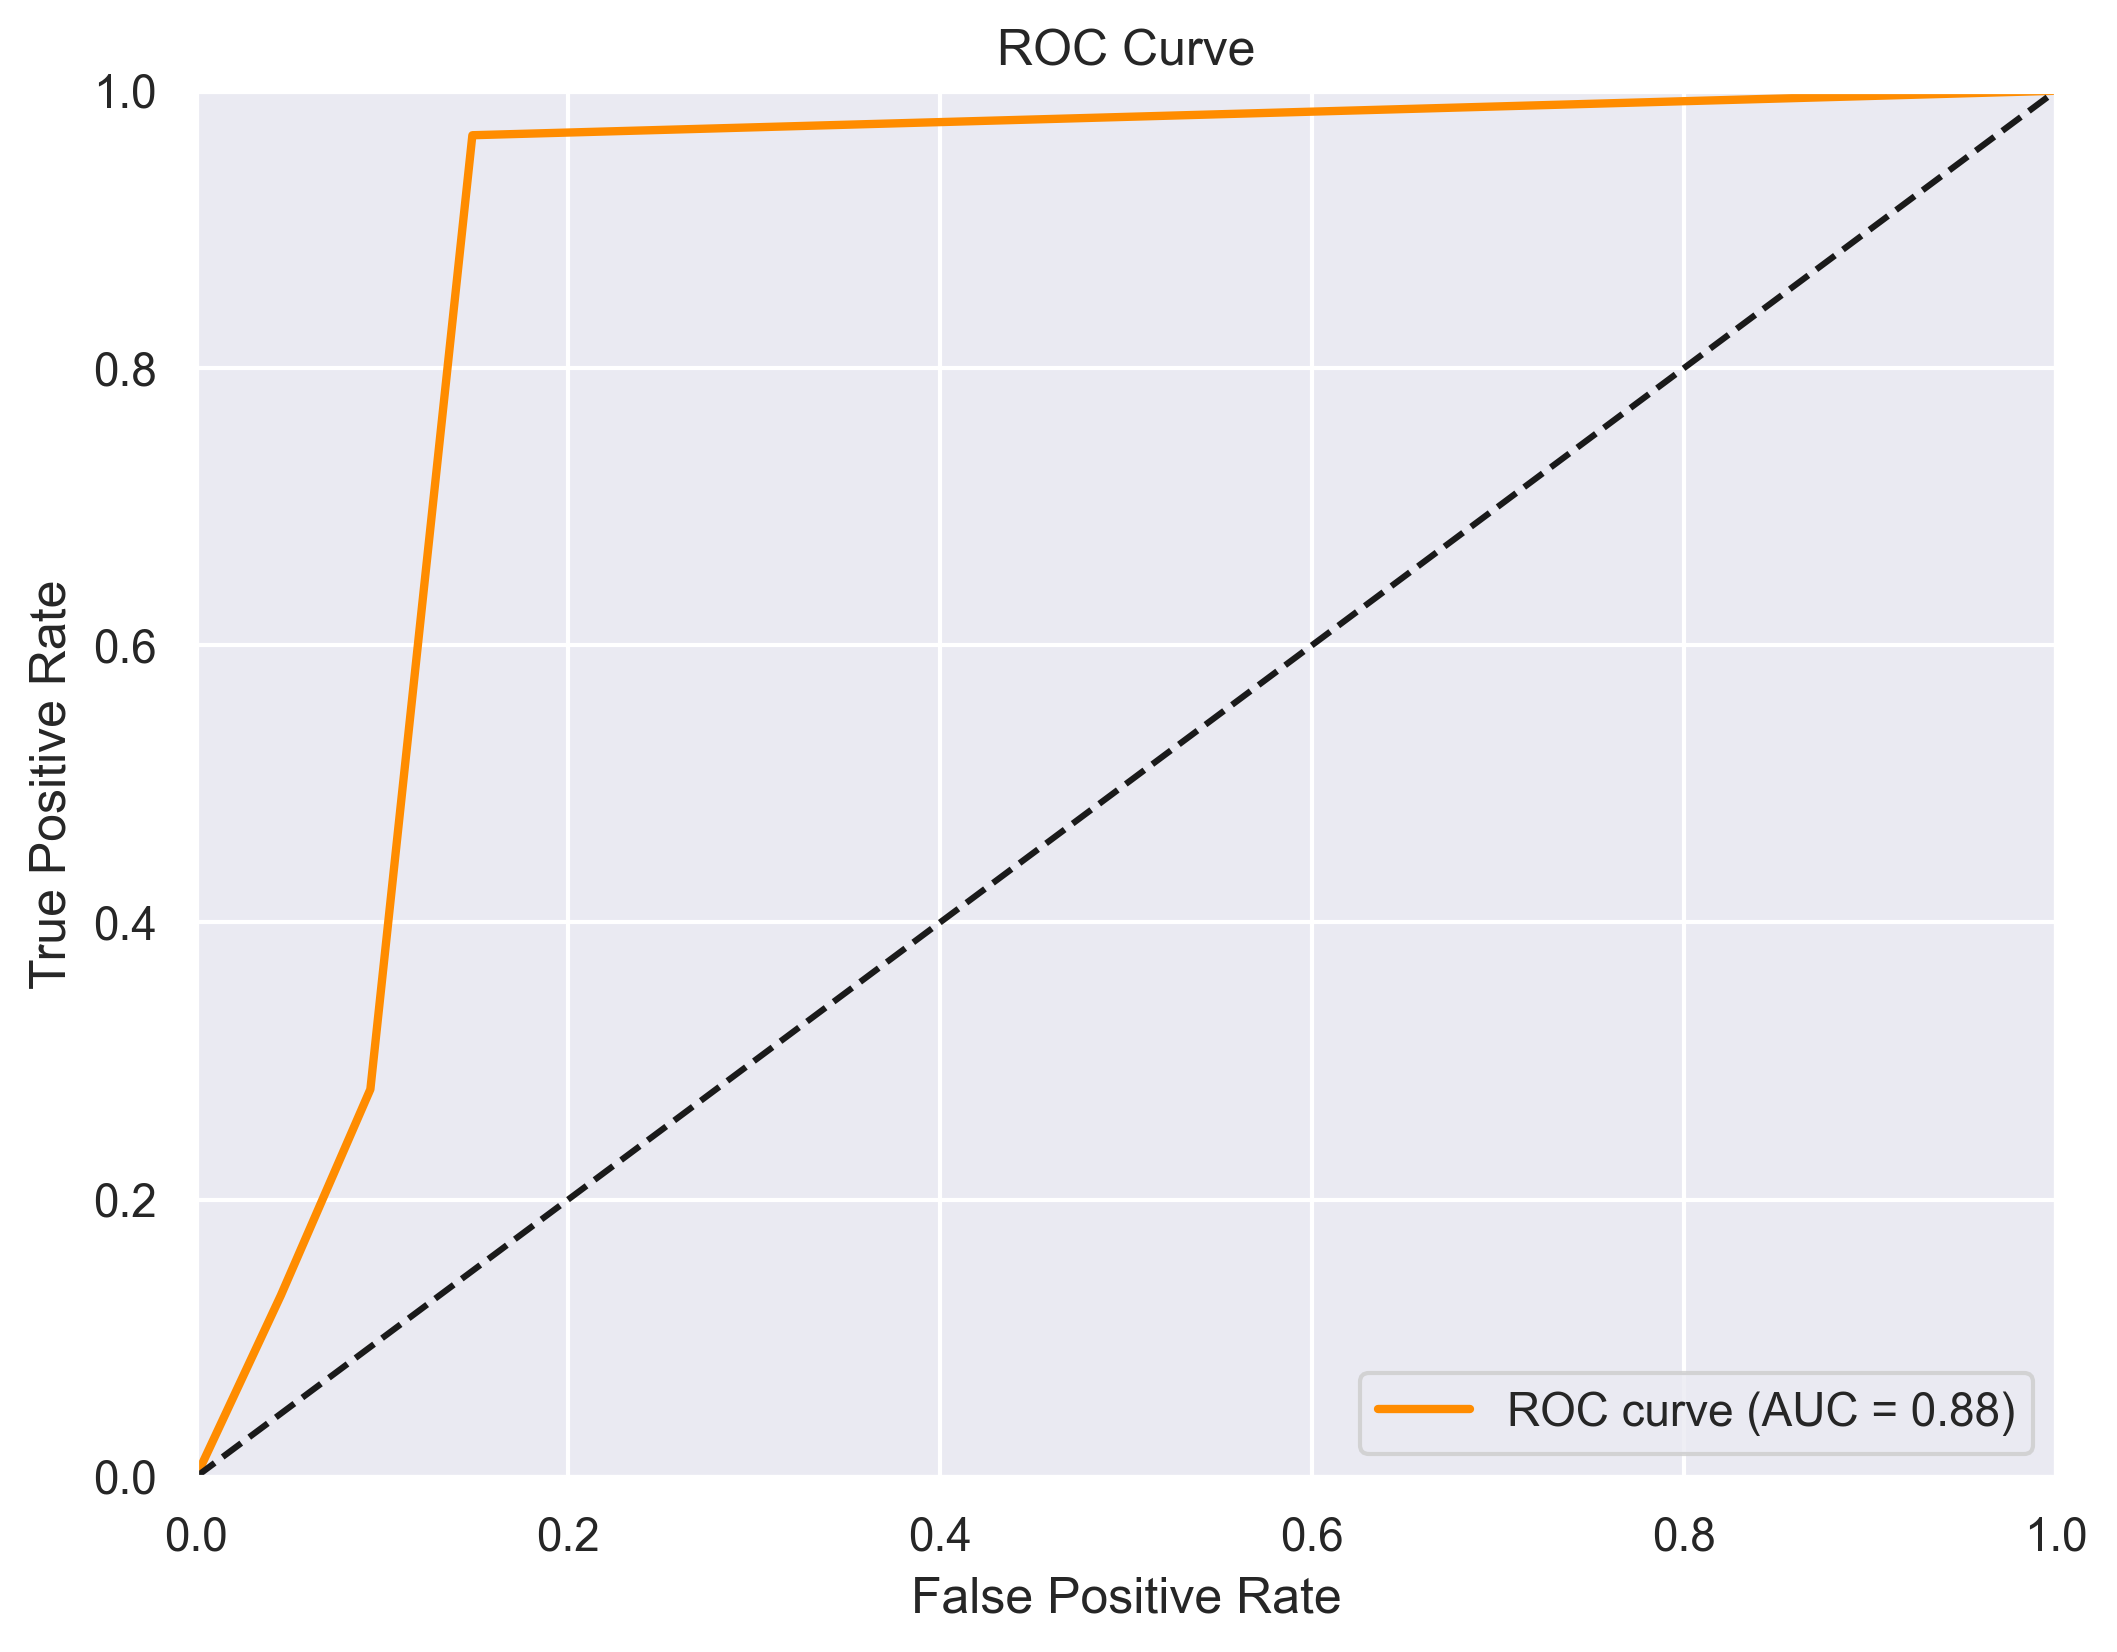

In [22]:
##  ROC曲线&AUC值
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, y_best_pred_xgb, pos_label=1)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_xgb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig(fname="XGBoost_ROC曲线.png")

### 2.8 LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1475
[LightGBM] [Info] Number of data points in the train set: 191944, number of used features: 11
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
LightGBM最佳参数: {'learning_rate': 0.1, 'min_child_samples': 50, 'n_estimators': 150, 'num_leaves': 50}
LightGBM最佳得分: 0.9172623369801108
LightGBM模型预测准确率: 0.9480365605958023
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     20427
           1       0.65      0.72      0.68      1184
           2     

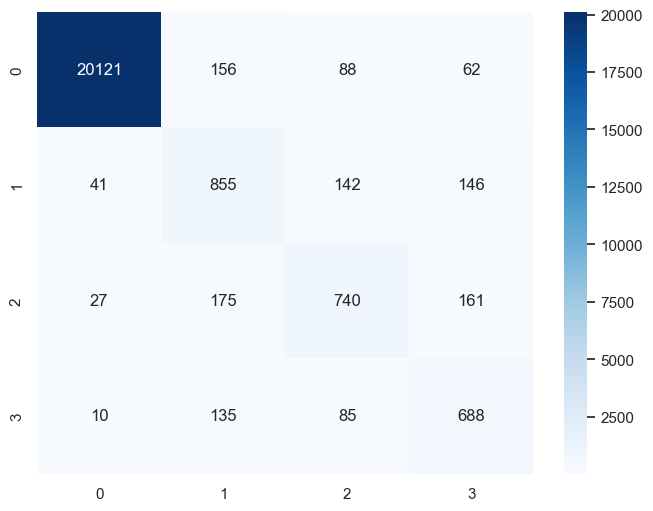

In [23]:
## 8、LightGBM
# 网格搜索
param_grid = {
    'n_estimators': [100, 150],  # 树的数量
    'learning_rate': [0.01, 0.1],  # 学习率
    'num_leaves': [20, 50],  # 叶子节点数
    'min_child_samples': [50, 100]  # 一个叶子节点上包含的最少样本数
}

# 创建LightGBM分类器模型实例，四分类
lgb_model = lgb.LGBMClassifier(objective='multiclass', metric='multi_logloss', random_state=0)

# 创建网格搜索对象
grid_search_lgb = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring='accuracy',  # 使用准确率作为评估指标
    cv=5,  # 5折交叉验证
    n_jobs=-1  # 使用所有可用的CPU核心进行并行计算
)

# 在训练数据上执行网格搜索
grid_search_lgb.fit(X_train, y_train)

# 获取最佳参数
best_params_lgb = grid_search_lgb.best_params_
print("LightGBM最佳参数:", best_params_lgb)

# 获取最佳模型
best_model_lgb = grid_search_lgb.best_estimator_

# 获取最佳得分（在交叉验证集上的平均准确率）
best_score_lgb = grid_search_lgb.best_score_
print("LightGBM最佳得分:", best_score_lgb)

# 使用最佳模型进行预测和评估
y_best_pred_lgb = best_model_lgb.predict(X_test)

# 计算准确率Accuracy
accuracy_lgb = accuracy_score(y_test, y_best_pred_lgb)
print("LightGBM模型预测准确率:", accuracy_lgb)

# 精确率precision、召回率recall、F1值f1score等
print(classification_report(y_test, y_best_pred_lgb))

# 混淆矩阵
conf_matrix_lgb = confusion_matrix(y_test, y_best_pred_lgb)

# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lgb, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="LightGBM混淆矩阵.png")

In [24]:
temp = store_results("LightGBM", y_train, X_train, y_test, X_test, best_model_lgb, 5)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.864379,NaN,0.000000,0.864379,NaN,0.000000,0.249995,0.249993,0.249993,0.249993,0.249993,0.250000
1,logistic,0.786814,0.195408,0.556000,0.786814,0.195408,0.556000,0.443812,0.446013,0.444763,0.444711,0.440334,0.443237
2,决策树,0.826803,0.402211,0.947883,0.826803,0.402211,0.947883,0.632653,0.633306,0.634192,0.627602,0.632134,0.636032
3,KNN,0.803487,0.342152,0.754130,0.803487,0.342152,0.754130,0.903248,0.903045,0.902081,0.901013,0.904348,0.905752
4,XGBoost,0.895227,0.506841,0.955451,0.895227,0.506841,0.955451,0.788193,0.790252,0.789653,0.783323,0.791086,0.786652
5,LightGBM,0.948037,0.845697,0.954241,0.948037,0.845697,0.954241,0.917262,0.912084,0.920915,0.916747,0.917294,0.919272


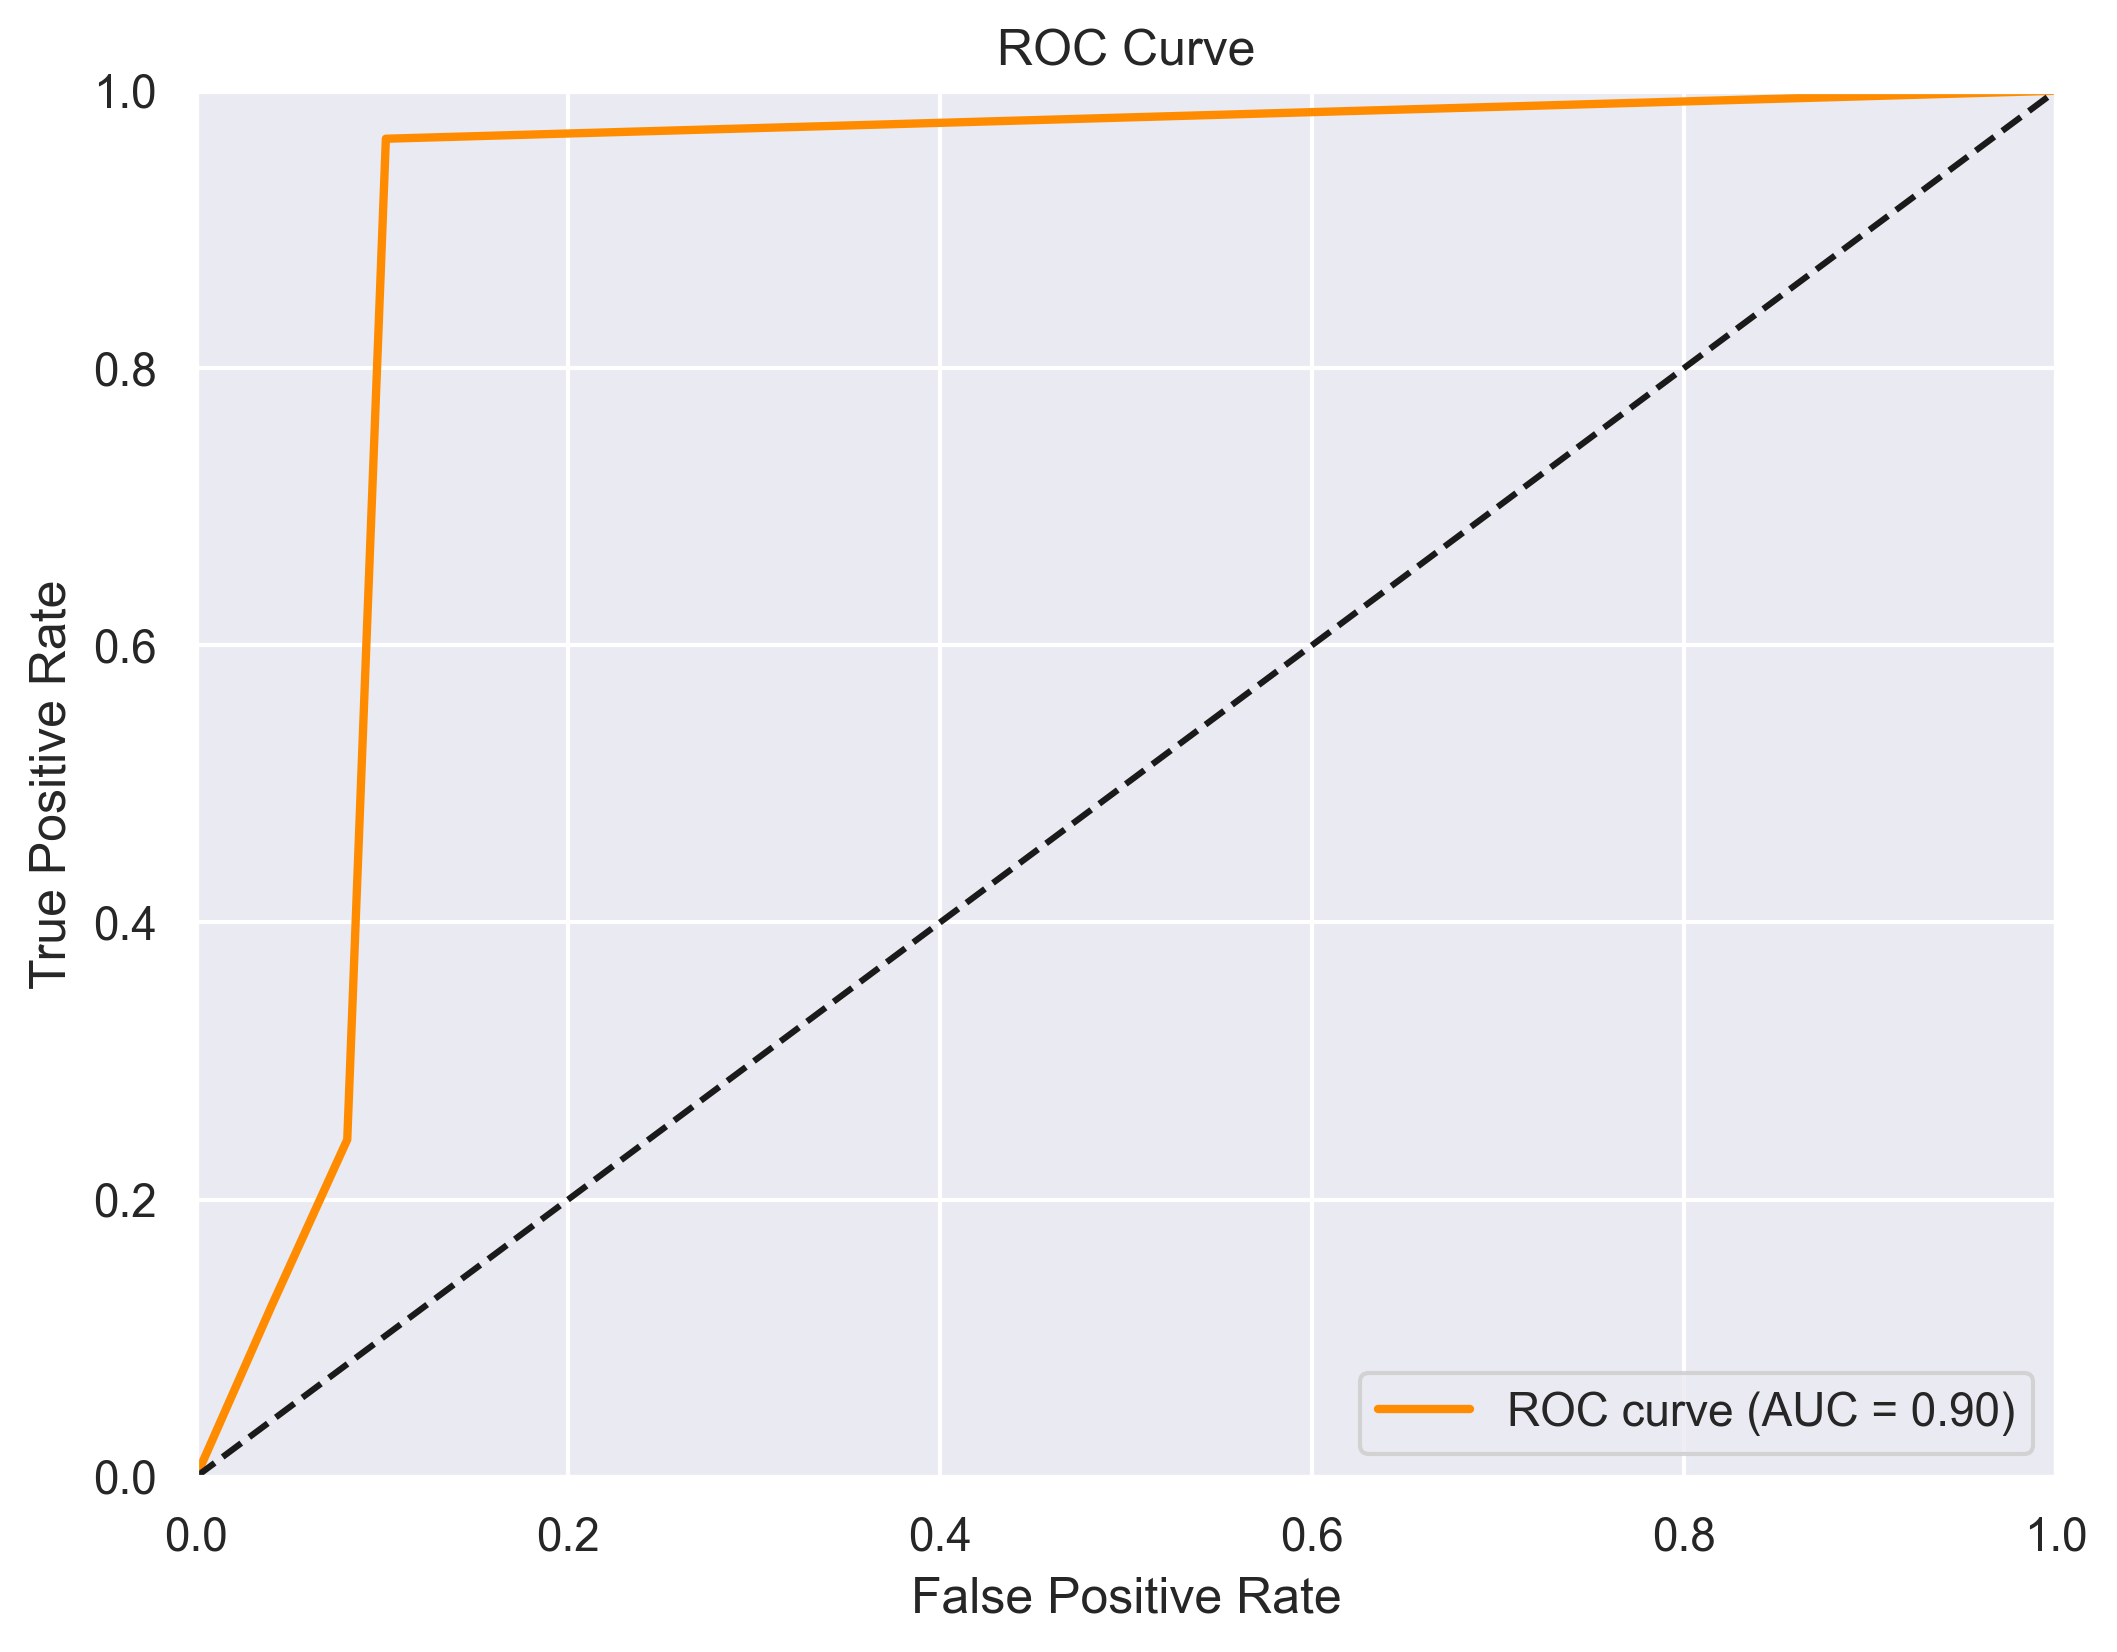

In [25]:
##  ROC曲线&AUC值
fpr_lgb, tpr_lgb, thresholds = roc_curve(y_test, y_best_pred_lgb, pos_label=1)
auc_lgb = auc(fpr_lgb, tpr_lgb)

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr_lgb, tpr_lgb, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_lgb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig(fname="LightGBM_ROC曲线.png")

# 保存y_best_pred_lgb
y_best_pred_lgb = pd.DataFrame(y_best_pred_lgb)
y_best_pred_lgb.to_csv("y_pred_Cluster3.csv")

### 2.9 Bagging
组合Decision Tree/SVM/Logistic

bagging预测准确率: 0.9541723087339201
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     20427
           1       0.70      0.72      0.71      1184
           2       0.71      0.71      0.71      1103
           3       0.68      0.76      0.72       918

    accuracy                           0.95     23632
   macro avg       0.77      0.80      0.78     23632
weighted avg       0.96      0.95      0.95     23632



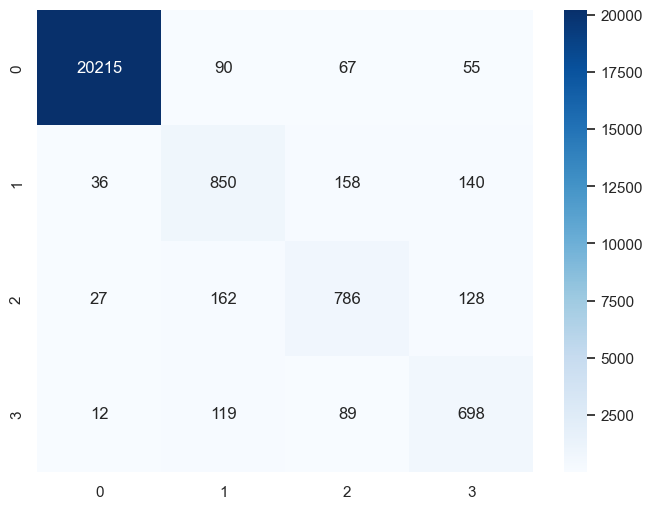

In [26]:
## 9、Bagging
# 组合Decision Tree/SVM/Logistic
base_estimators = [
    ('dt', DecisionTreeClassifier()),
    ('svc', SVC(probability=True)),
    ('lr', LogisticRegression())
]

# 创建BaggingClassifier实例，使用不同的基分类器进行集成
bag_model = BaggingClassifier(
    estimator=None,
    n_estimators=500,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True
)
bag_model.estimators_ = [est[1] for est in base_estimators]  # 设置多种基分类器

bag_model.fit(X_train, y_train)

y_bag_pred = bag_model.predict(X_test)

# 准确率Accuracy--正确分类的样本数占总样本数的比例
accuracy = accuracy_score(y_test, y_bag_pred)
print("bagging预测准确率:", accuracy)

# 精确率precision--被分类器预测为正类的样本中，真正为正类的样本所占的比例
# 召回率recall--真正为正类的样本中，被分类器预测为正类的样本所占的比例
# F1值f1score--综合考虑精确率和召回率，精确率和召回率的调和平均数
print(classification_report(y_test, y_bag_pred))

## 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_bag_pred)

# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="bagging混淆矩阵.png")

In [27]:
temp = store_results("Bagging", y_train, X_train, y_test, X_test, bag_model, 5)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1468
[LightGBM] [Info] Number of data points in the train set: 153555, number of used features: 11
[LightGBM] [Info] Start training from score -1.386314
[LightGBM] [Info] Start training from score -1.386288
[LightGBM] [Info] Start training from score -1.386288
[LightGBM] [Info] Start training from score -1.386288
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1468
[LightGBM]

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.864379,NaN,0.000000,0.864379,NaN,0.000000,0.249995,0.249993,0.249993,0.249993,0.249993,0.250000
1,logistic,0.786814,0.195408,0.556000,0.786814,0.195408,0.556000,0.443812,0.446013,0.444763,0.444711,0.440334,0.443237
2,决策树,0.826803,0.402211,0.947883,0.826803,0.402211,0.947883,0.632653,0.633306,0.634192,0.627602,0.632134,0.636032
3,KNN,0.803487,0.342152,0.754130,0.803487,0.342152,0.754130,0.903248,0.903045,0.902081,0.901013,0.904348,0.905752
4,XGBoost,0.895227,0.506841,0.955451,0.895227,0.506841,0.955451,0.788193,0.790252,0.789653,0.783323,0.791086,0.786652
5,LightGBM,0.948037,0.845697,0.954241,0.948037,0.845697,0.954241,0.917262,0.912084,0.920915,0.916747,0.917294,0.919272
6,Bagging,0.954172,0.904255,0.959368,0.954172,0.904255,0.959368,0.974758,0.970538,0.976061,0.975227,0.976113,0.975852


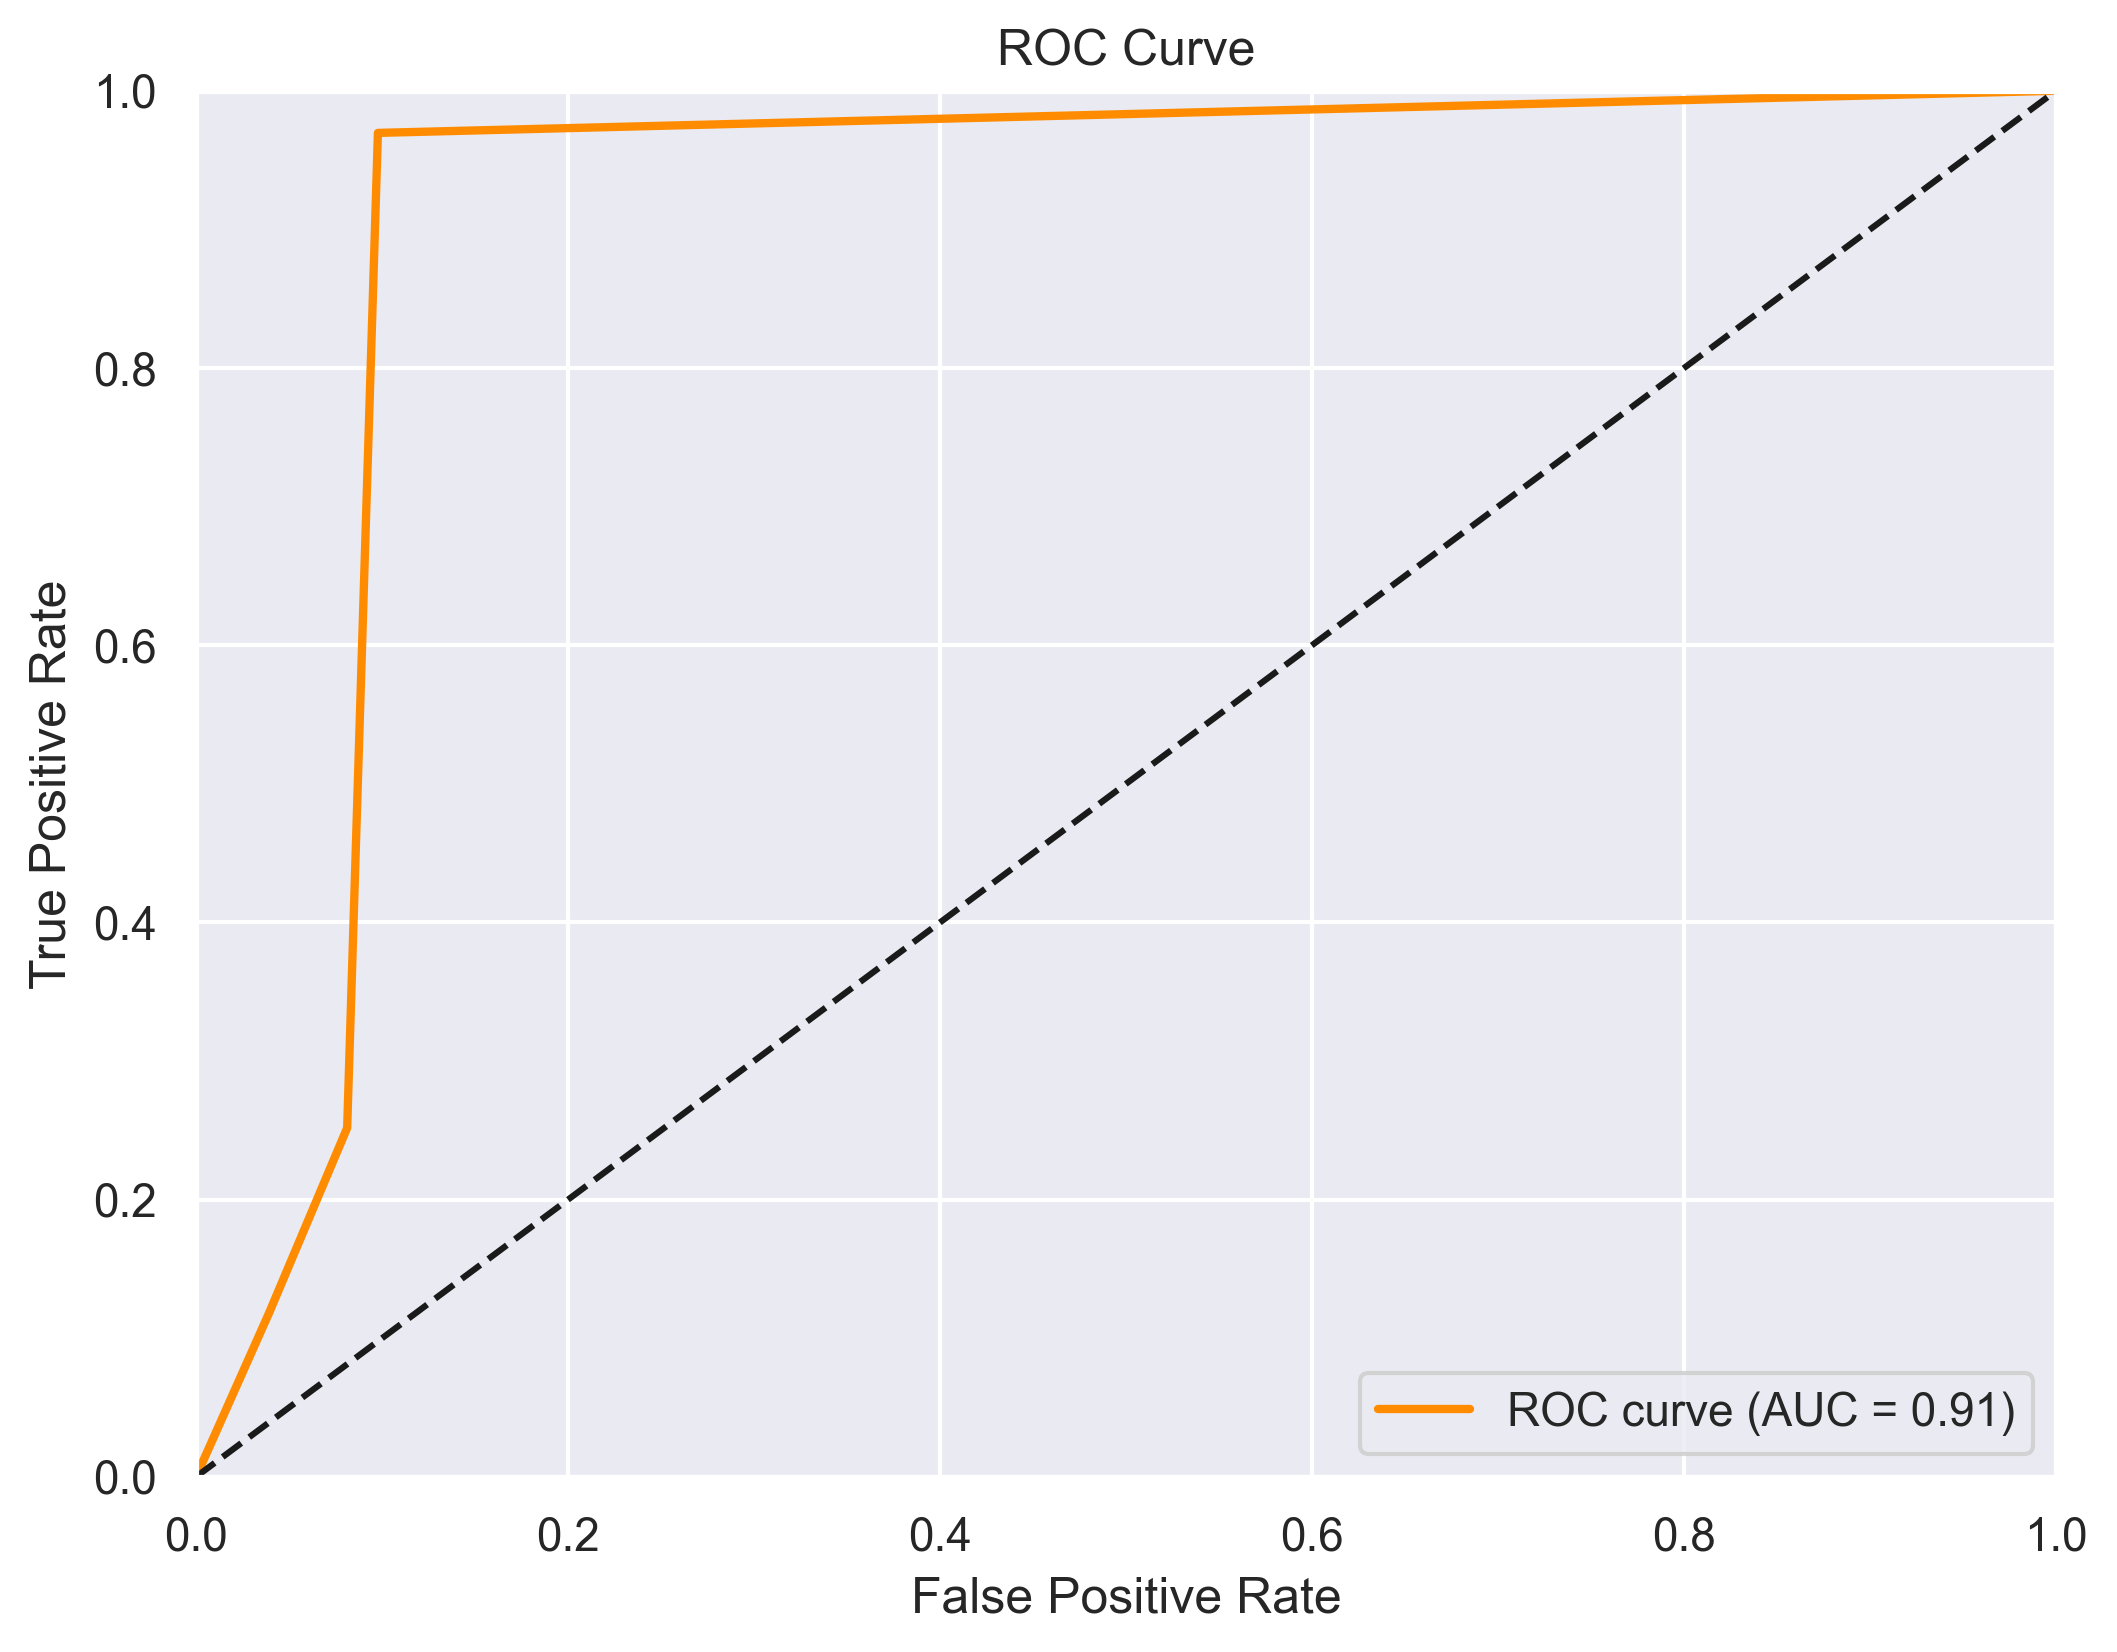

In [28]:
##  ROC曲线&AUC值
fpr_bag, tpr_bag, thresholds = roc_curve(y_test, y_bag_pred, pos_label=1)
auc_bag = auc(fpr_bag, tpr_bag)

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr_bag, tpr_bag, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_bag)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig(fname="Bagging_ROC曲线.png")

### 2.10 Random Forest

Random Forest最佳参数: {'max_depth': 5, 'min_samples_split': 50, 'n_estimators': 150}
Random Forest最佳得分: 0.5704267891736261
Random Forest模型预测准确率: 0.8287068381855112
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     20427
           1       0.21      0.54      0.30      1184
           2       0.30      0.33      0.31      1103
           3       0.39      0.41      0.40       918

    accuracy                           0.83     23632
   macro avg       0.47      0.54      0.49     23632
weighted avg       0.90      0.83      0.86     23632



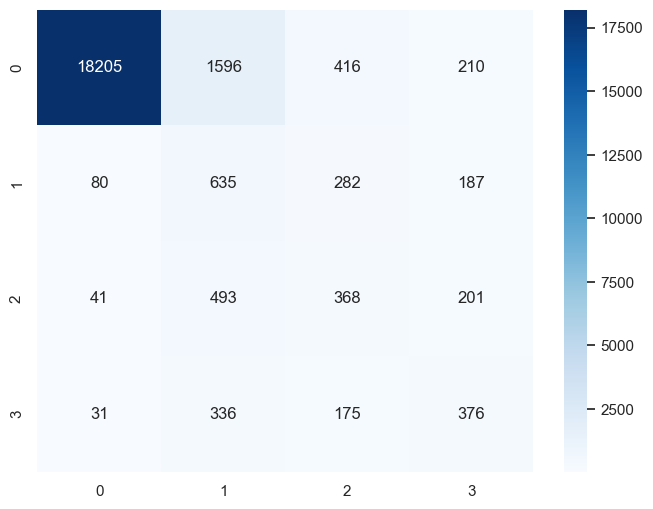

In [29]:
## 10、Random Forest
# 网格搜索
param_grid = {
    'n_estimators': [100, 150],  # 树的数量
    'max_depth': [3, 5],  # 最大深度
    'min_samples_split': [50, 100],  # 内部节点再划分所需最小样本数
}

# 创建Random Forest分类器模型实例
rf_model = RandomForestClassifier(random_state=0)

# 创建网格搜索对象
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='accuracy',  # 使用准确率作为评估指标
    cv=5,  # 5折交叉验证
    n_jobs=-1  # 使用所有可用的CPU核心进行并行计算
)

# 在训练数据上执行网格搜索
grid_search_rf.fit(X_train, y_train)

# 获取最佳参数
best_params_rf = grid_search_rf.best_params_
print("Random Forest最佳参数:", best_params_rf)

# 获取最佳模型
best_model_rf = grid_search_rf.best_estimator_

# 获取最佳得分（在交叉验证集上的平均准确率）
best_score_rf = grid_search_rf.best_score_
print("Random Forest最佳得分:", best_score_rf)

# 使用最佳模型进行预测和评估
y_best_pred_rf = best_model_rf.predict(X_test)

# 计算准确率Accuracy
accuracy_rf = accuracy_score(y_test, y_best_pred_rf)
print("Random Forest模型预测准确率:", accuracy_rf)

# 精确率precision、召回率recall、F1值f1score等
print(classification_report(y_test, y_best_pred_rf))

# 混淆矩阵
conf_matrix_rf = confusion_matrix(y_test, y_best_pred_rf)

# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="Random Forest混淆矩阵.png")

In [30]:
temp = store_results("Random Forest", y_train, X_train, y_test, X_test, best_model_rf, 5)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.864379,NaN,0.000000,0.864379,NaN,0.000000,0.249995,0.249993,0.249993,0.249993,0.249993,0.250000
1,logistic,0.786814,0.195408,0.556000,0.786814,0.195408,0.556000,0.443812,0.446013,0.444763,0.444711,0.440334,0.443237
2,决策树,0.826803,0.402211,0.947883,0.826803,0.402211,0.947883,0.632653,0.633306,0.634192,0.627602,0.632134,0.636032
3,KNN,0.803487,0.342152,0.754130,0.803487,0.342152,0.754130,0.903248,0.903045,0.902081,0.901013,0.904348,0.905752
4,XGBoost,0.895227,0.506841,0.955451,0.895227,0.506841,0.955451,0.788193,0.790252,0.789653,0.783323,0.791086,0.786652
5,LightGBM,0.948037,0.845697,0.954241,0.948037,0.845697,0.954241,0.917262,0.912084,0.920915,0.916747,0.917294,0.919272
6,Bagging,0.954172,0.904255,0.959368,0.954172,0.904255,0.959368,0.974758,0.970538,0.976061,0.975227,0.976113,0.975852
7,Random Forest,0.828707,0.284626,0.888112,0.828707,0.284626,0.888112,0.570427,0.571883,0.573055,0.570684,0.566464,0.570048


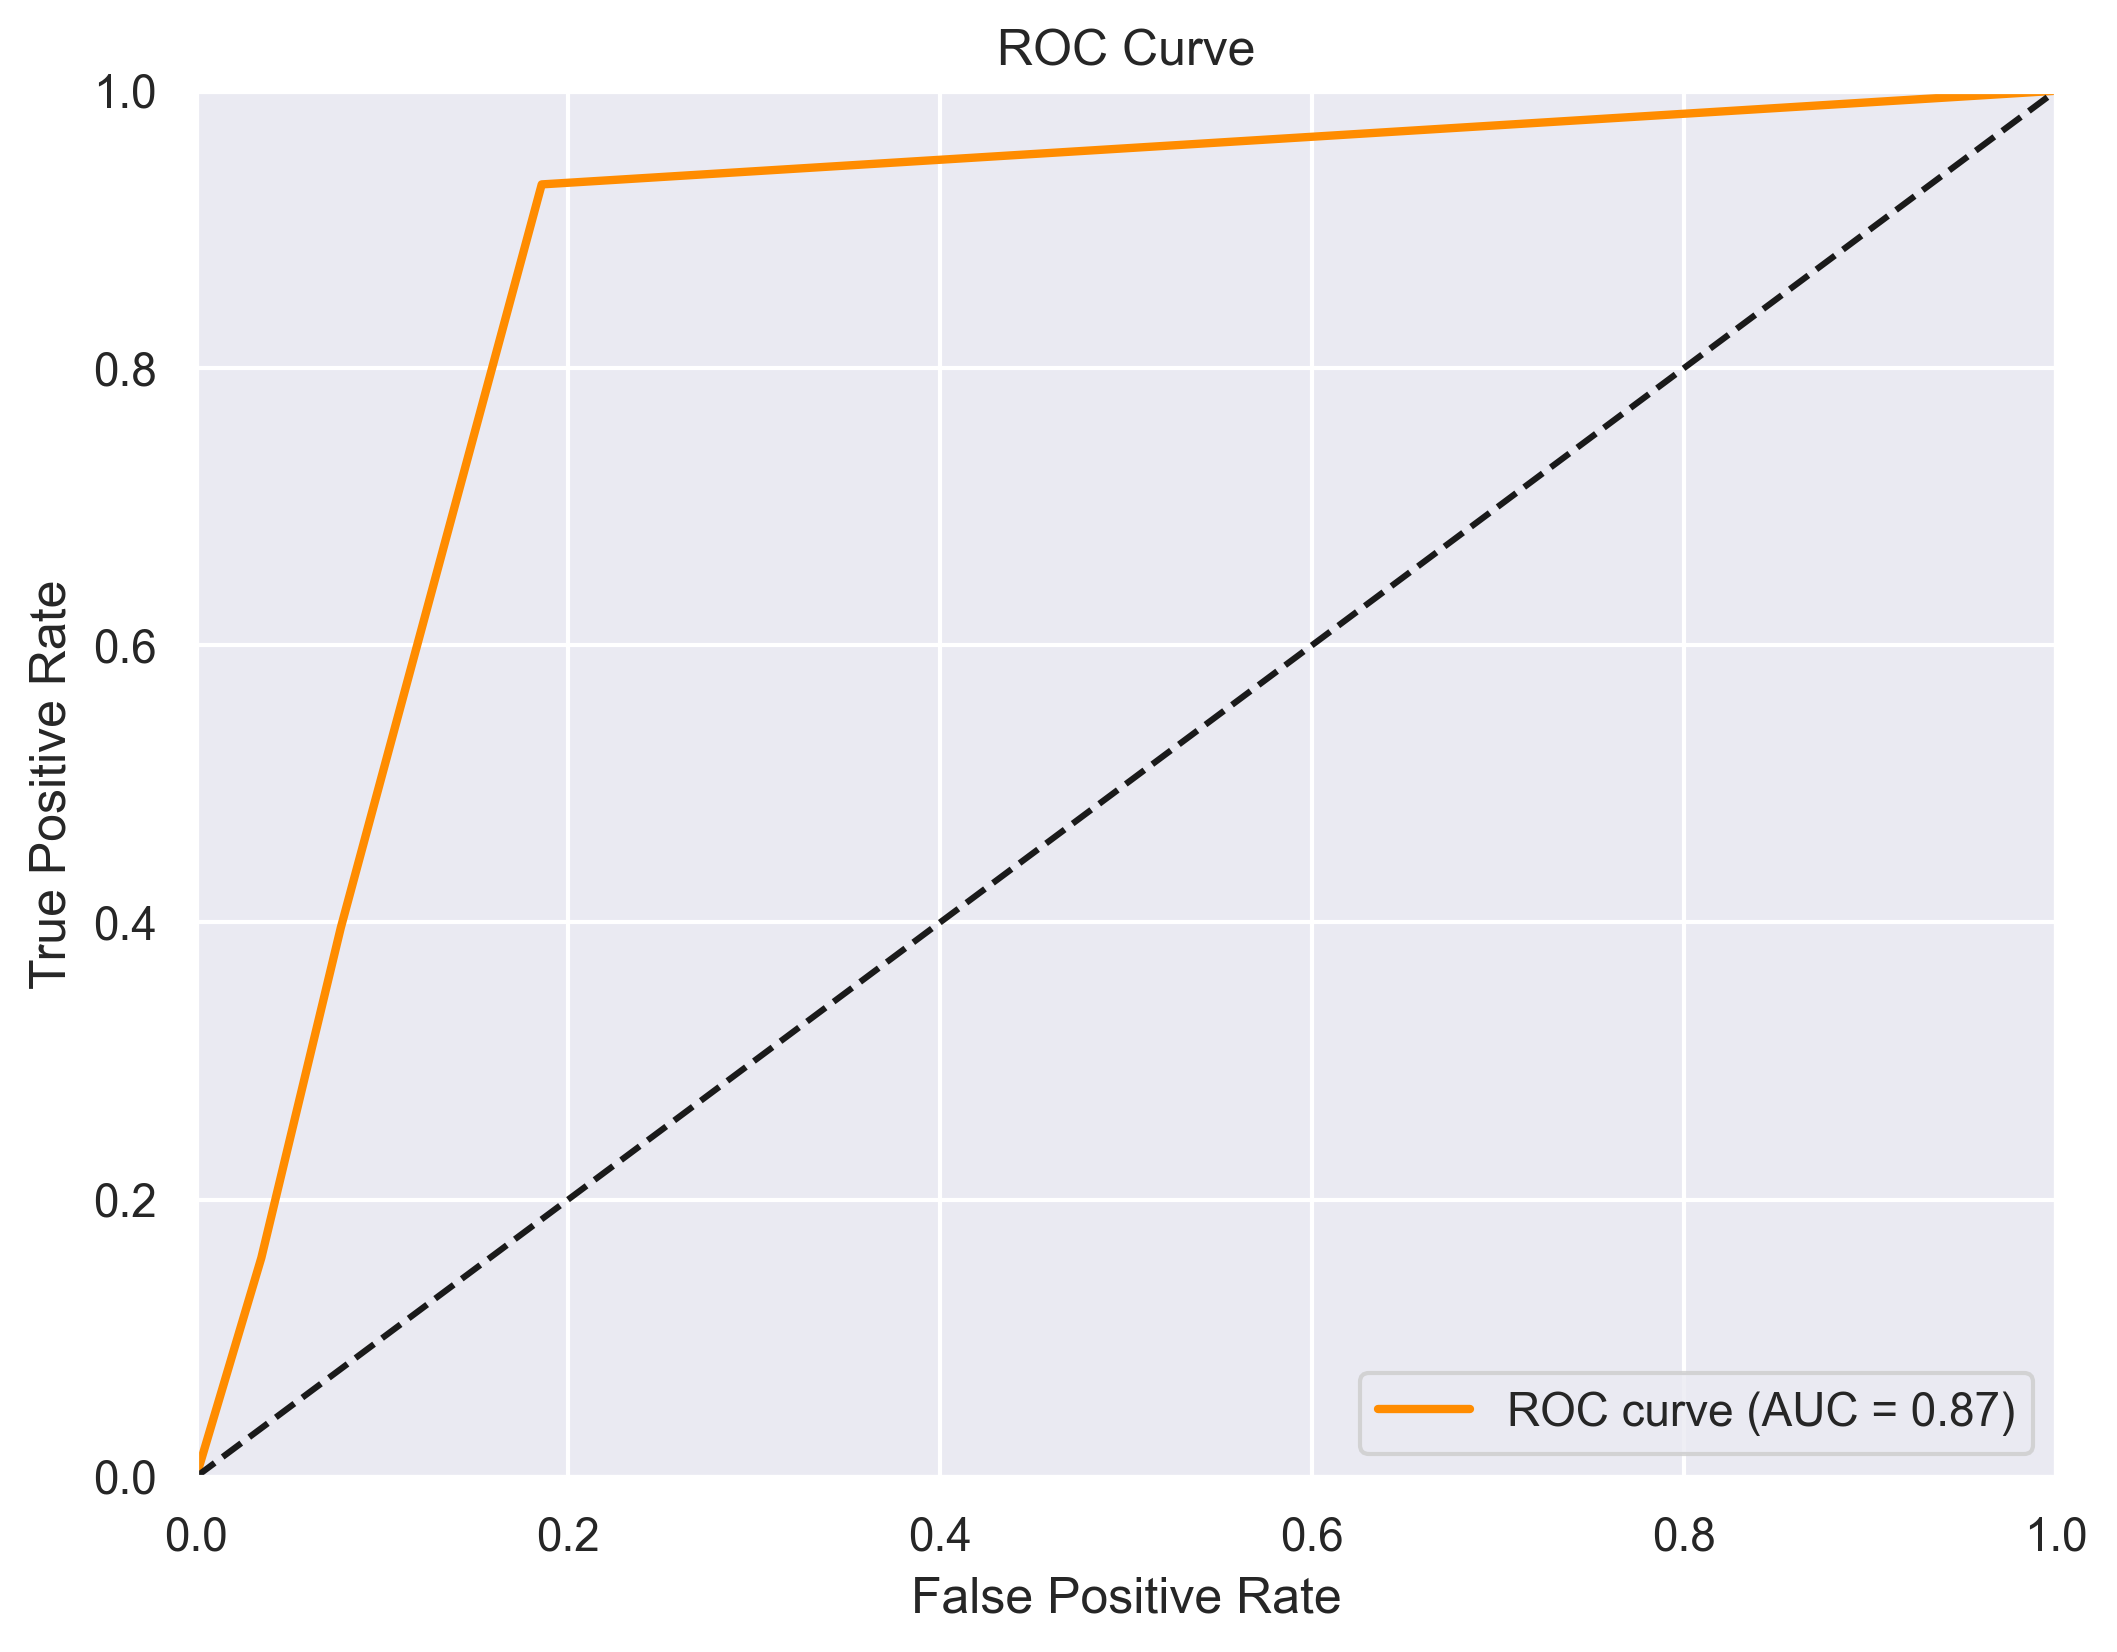

In [31]:
# ROC曲线&AUC值
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_best_pred_rf, pos_label=1)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_rf)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig(fname="Random Forest_ROC曲线.png")

### 2.11 Stacking

HGB最佳参数: {'l2_regularization': 0.01, 'learning_rate': 0.1}
HGB最佳得分: 0.8721919075272598
stacking预测准确率: 0.9336069735951252
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     20427
           1       0.57      0.71      0.63      1184
           2       0.63      0.64      0.64      1103
           3       0.61      0.72      0.66       918

    accuracy                           0.93     23632
   macro avg       0.70      0.76      0.73     23632
weighted avg       0.94      0.93      0.94     23632



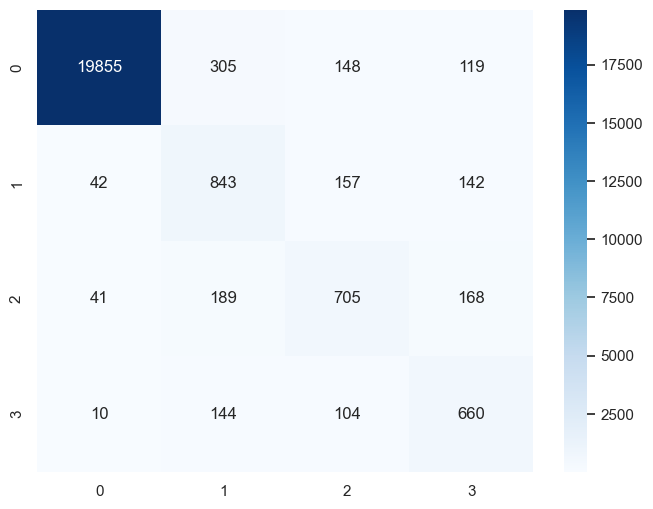

In [32]:
## 11、Stacking
# 组合Random Forestry/SVM/HGB
hgb = HistGradientBoostingClassifier(verbose=0)

paparam_grid = {
    'learning_rate' : [0.1 ,0.01],
    'l2_regularization' : [0.01, 0.1],
}

# 创建网格搜索对象
clf = GridSearchCV(
    estimator=hgb,
    param_grid=paparam_grid,
    scoring='accuracy',  # 使用准确率作为评估指标
    cv=5,  # 5折交叉验证
    n_jobs=-1  # 使用所有可用的CPU核心进行并行计算
)

clf.fit(X_train, y_train)

# 获取最佳参数
best_params = clf.best_params_
print("HGB最佳参数:", best_params)

# 获取最佳模型
best_model = clf.best_estimator_

# 获取最佳得分（在交叉验证集上的平均准确率）
best_score = clf.best_score_
print("HGB最佳得分:", best_score)

# 模型拟合
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', make_pipeline(StandardScaler(),
                        SVC(random_state=42,kernel='rbf'))),
    ('hgb', clf.best_estimator_)
]

stacking = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

clf.fit(X_train, y_train).score(X_test, y_test)

## 模型评估
y_stacking_pred = clf.predict(X_test)

# 准确率Accuracy--正确分类的样本数占总样本数的比例
accuracy = accuracy_score(y_test, y_stacking_pred)
print("stacking预测准确率:", accuracy)

# 精确率precision--被分类器预测为正类的样本中，真正为正类的样本所占的比例
# 召回率recall--真正为正类的样本中，被分类器预测为正类的样本所占的比例
# F1值f1score--综合考虑精确率和召回率，精确率和召回率的调和平均数
print(classification_report(y_test, y_stacking_pred))

## 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_stacking_pred)

# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="stacking混淆矩阵.png")

In [33]:
temp = store_results("Stacking", y_train, X_train, y_test, X_test, best_model, 5)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.864379,NaN,0.000000,0.864379,NaN,0.000000,0.249995,0.249993,0.249993,0.249993,0.249993,0.250000
1,logistic,0.786814,0.195408,0.556000,0.786814,0.195408,0.556000,0.443812,0.446013,0.444763,0.444711,0.440334,0.443237
2,决策树,0.826803,0.402211,0.947883,0.826803,0.402211,0.947883,0.632653,0.633306,0.634192,0.627602,0.632134,0.636032
3,KNN,0.803487,0.342152,0.754130,0.803487,0.342152,0.754130,0.903248,0.903045,0.902081,0.901013,0.904348,0.905752
4,XGBoost,0.895227,0.506841,0.955451,0.895227,0.506841,0.955451,0.788193,0.790252,0.789653,0.783323,0.791086,0.786652
5,LightGBM,0.948037,0.845697,0.954241,0.948037,0.845697,0.954241,0.917262,0.912084,0.920915,0.916747,0.917294,0.919272
6,Bagging,0.954172,0.904255,0.959368,0.954172,0.904255,0.959368,0.974758,0.970538,0.976061,0.975227,0.976113,0.975852
7,Random Forest,0.828707,0.284626,0.888112,0.828707,0.284626,0.888112,0.570427,0.571883,0.573055,0.570684,0.566464,0.570048
8,Stacking,0.934326,0.725779,0.953409,0.934326,0.725779,0.953409,0.870520,0.866264,0.871656,0.871343,0.871317,0.872017


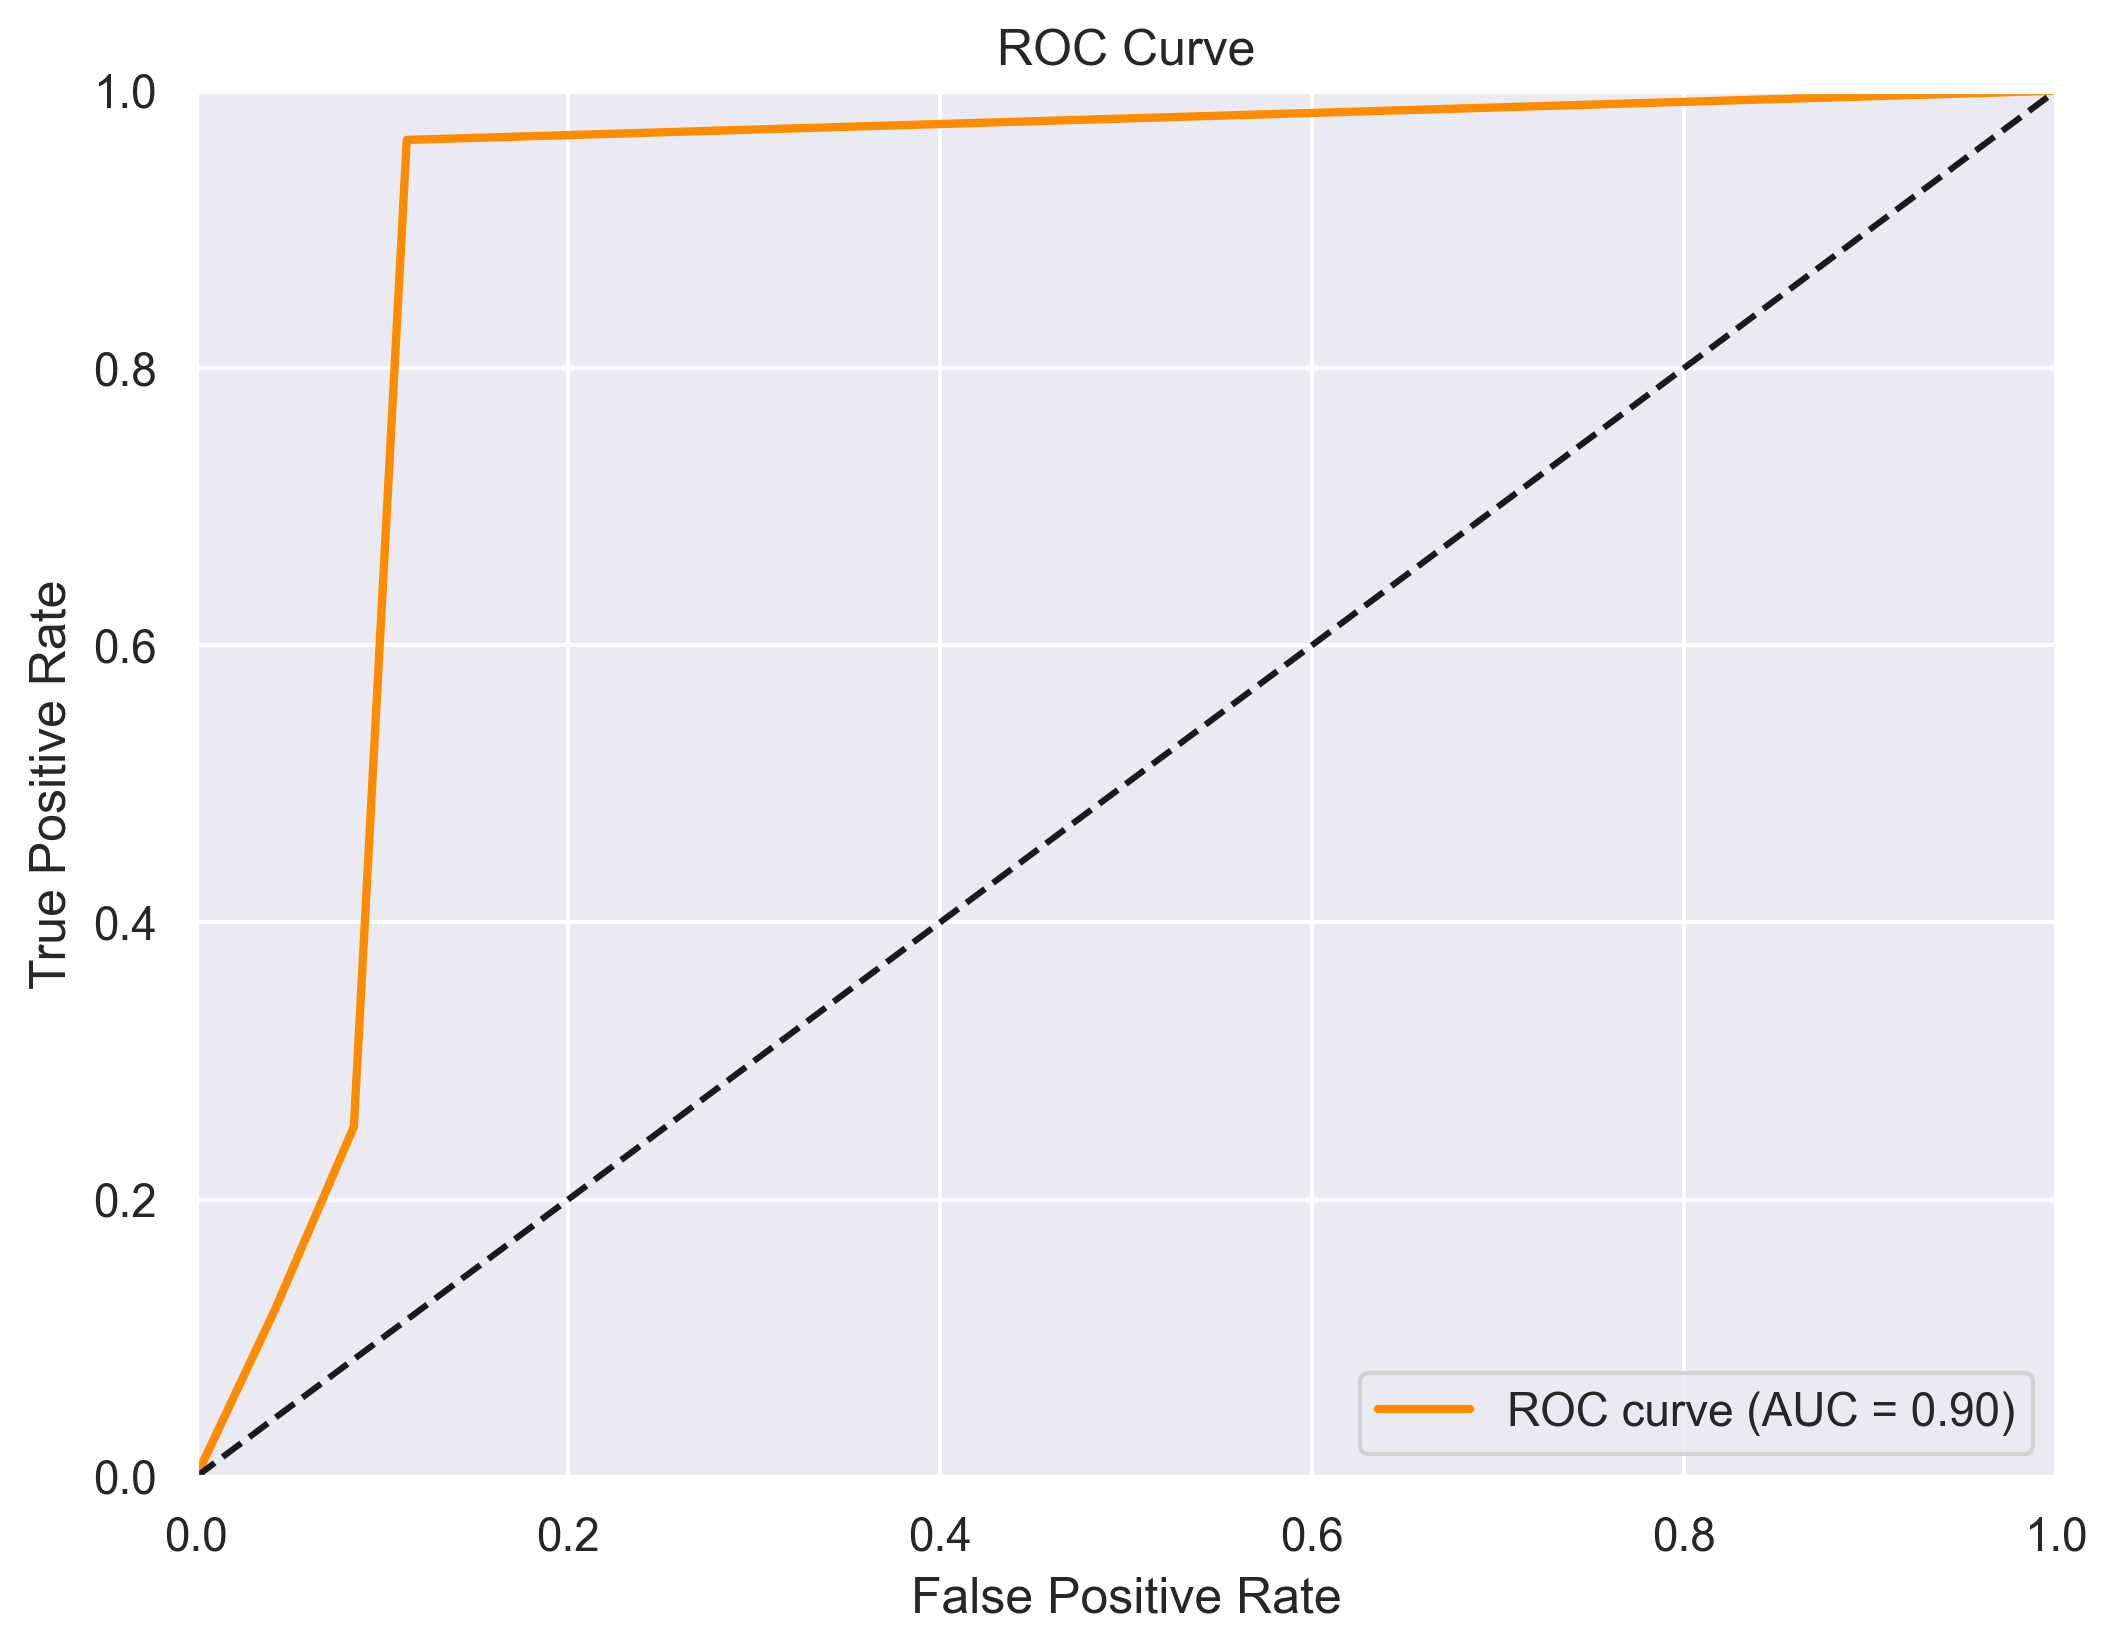

In [34]:
# ROC曲线&AUC值
fpr_stacking, tpr_stacking, thresholds = roc_curve(y_test, y_stacking_pred, pos_label=1)
auc_stacking = auc(fpr_stacking, tpr_stacking)

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr_stacking, tpr_stacking, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_stacking)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig(fname="Stacking_ROC曲线.png")

### 2.12 Voting

HGB最佳参数: {'l2_regularization': 0.1, 'learning_rate': 0.1}
HGB最佳得分: 0.8709727912060442
voting预测准确率: 0.9322528774542993
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     20427
           1       0.56      0.71      0.63      1184
           2       0.63      0.64      0.64      1103
           3       0.59      0.72      0.65       918

    accuracy                           0.93     23632
   macro avg       0.70      0.76      0.72     23632
weighted avg       0.94      0.93      0.94     23632



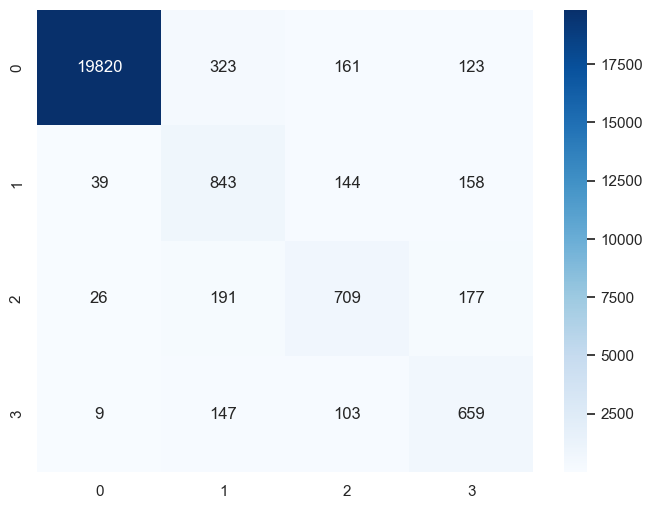

In [35]:
## 12、Voting
# 网格搜索
hgb = HistGradientBoostingClassifier(verbose=0)

paparam_grid = {
    'learning_rate' : [0.1,0.01],
    'l2_regularization' : [0.01, 0.1],
    
}

# 创建网格搜索对象
clf = GridSearchCV(
    estimator=hgb,
    param_grid=paparam_grid,
    scoring='accuracy',  # 使用准确率作为评估指标
    cv=5,  # 5折交叉验证
    n_jobs=-1  # 使用所有可用的CPU核心进行并行计算
)

clf.fit(X_train, y_train)

# 获取最佳参数
best_params = clf.best_params_
print("HGB最佳参数:", best_params)

# 获取最佳模型
best_model = clf.best_estimator_

# 获取最佳得分（在交叉验证集上的平均准确率）
best_score = clf.best_score_
print("HGB最佳得分:", best_score)

# 模型拟合
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', make_pipeline(StandardScaler(),
                        SVC(random_state=42,kernel='rbf'))),
    ('hgb', clf.best_estimator_)
]

voting = VotingClassifier(
    estimators=estimators, voting='hard'
)

clf.fit(X_train, y_train).score(X_test, y_test)

## 模型评估
y_voting_pred = clf.predict(X_test)

# 准确率Accuracy--正确分类的样本数占总样本数的比例
accuracy = accuracy_score(y_test, y_voting_pred)
print("voting预测准确率:", accuracy)

# 精确率precision--被分类器预测为正类的样本中，真正为正类的样本所占的比例
# 召回率recall--真正为正类的样本中，被分类器预测为正类的样本所占的比例
# F1值f1score--综合考虑精确率和召回率，精确率和召回率的调和平均数
print(classification_report(y_test, y_voting_pred))

## 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_voting_pred)

# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="voting混淆矩阵.png")

In [36]:
temp = store_results("Voting", y_train, X_train, y_test, X_test, best_model, 5)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.864379,NaN,0.000000,0.864379,NaN,0.000000,0.249995,0.249993,0.249993,0.249993,0.249993,0.250000
1,logistic,0.786814,0.195408,0.556000,0.786814,0.195408,0.556000,0.443812,0.446013,0.444763,0.444711,0.440334,0.443237
2,决策树,0.826803,0.402211,0.947883,0.826803,0.402211,0.947883,0.632653,0.633306,0.634192,0.627602,0.632134,0.636032
3,KNN,0.803487,0.342152,0.754130,0.803487,0.342152,0.754130,0.903248,0.903045,0.902081,0.901013,0.904348,0.905752
4,XGBoost,0.895227,0.506841,0.955451,0.895227,0.506841,0.955451,0.788193,0.790252,0.789653,0.783323,0.791086,0.786652
5,LightGBM,0.948037,0.845697,0.954241,0.948037,0.845697,0.954241,0.917262,0.912084,0.920915,0.916747,0.917294,0.919272
6,Bagging,0.954172,0.904255,0.959368,0.954172,0.904255,0.959368,0.974758,0.970538,0.976061,0.975227,0.976113,0.975852
7,Random Forest,0.828707,0.284626,0.888112,0.828707,0.284626,0.888112,0.570427,0.571883,0.573055,0.570684,0.566464,0.570048
8,Stacking,0.934326,0.725779,0.953409,0.934326,0.725779,0.953409,0.870520,0.866264,0.871656,0.871343,0.871317,0.872017
9,Voting,0.934792,0.740478,0.954338,0.934792,0.740478,0.954338,0.871186,0.868530,0.873610,0.868139,0.872333,0.873320


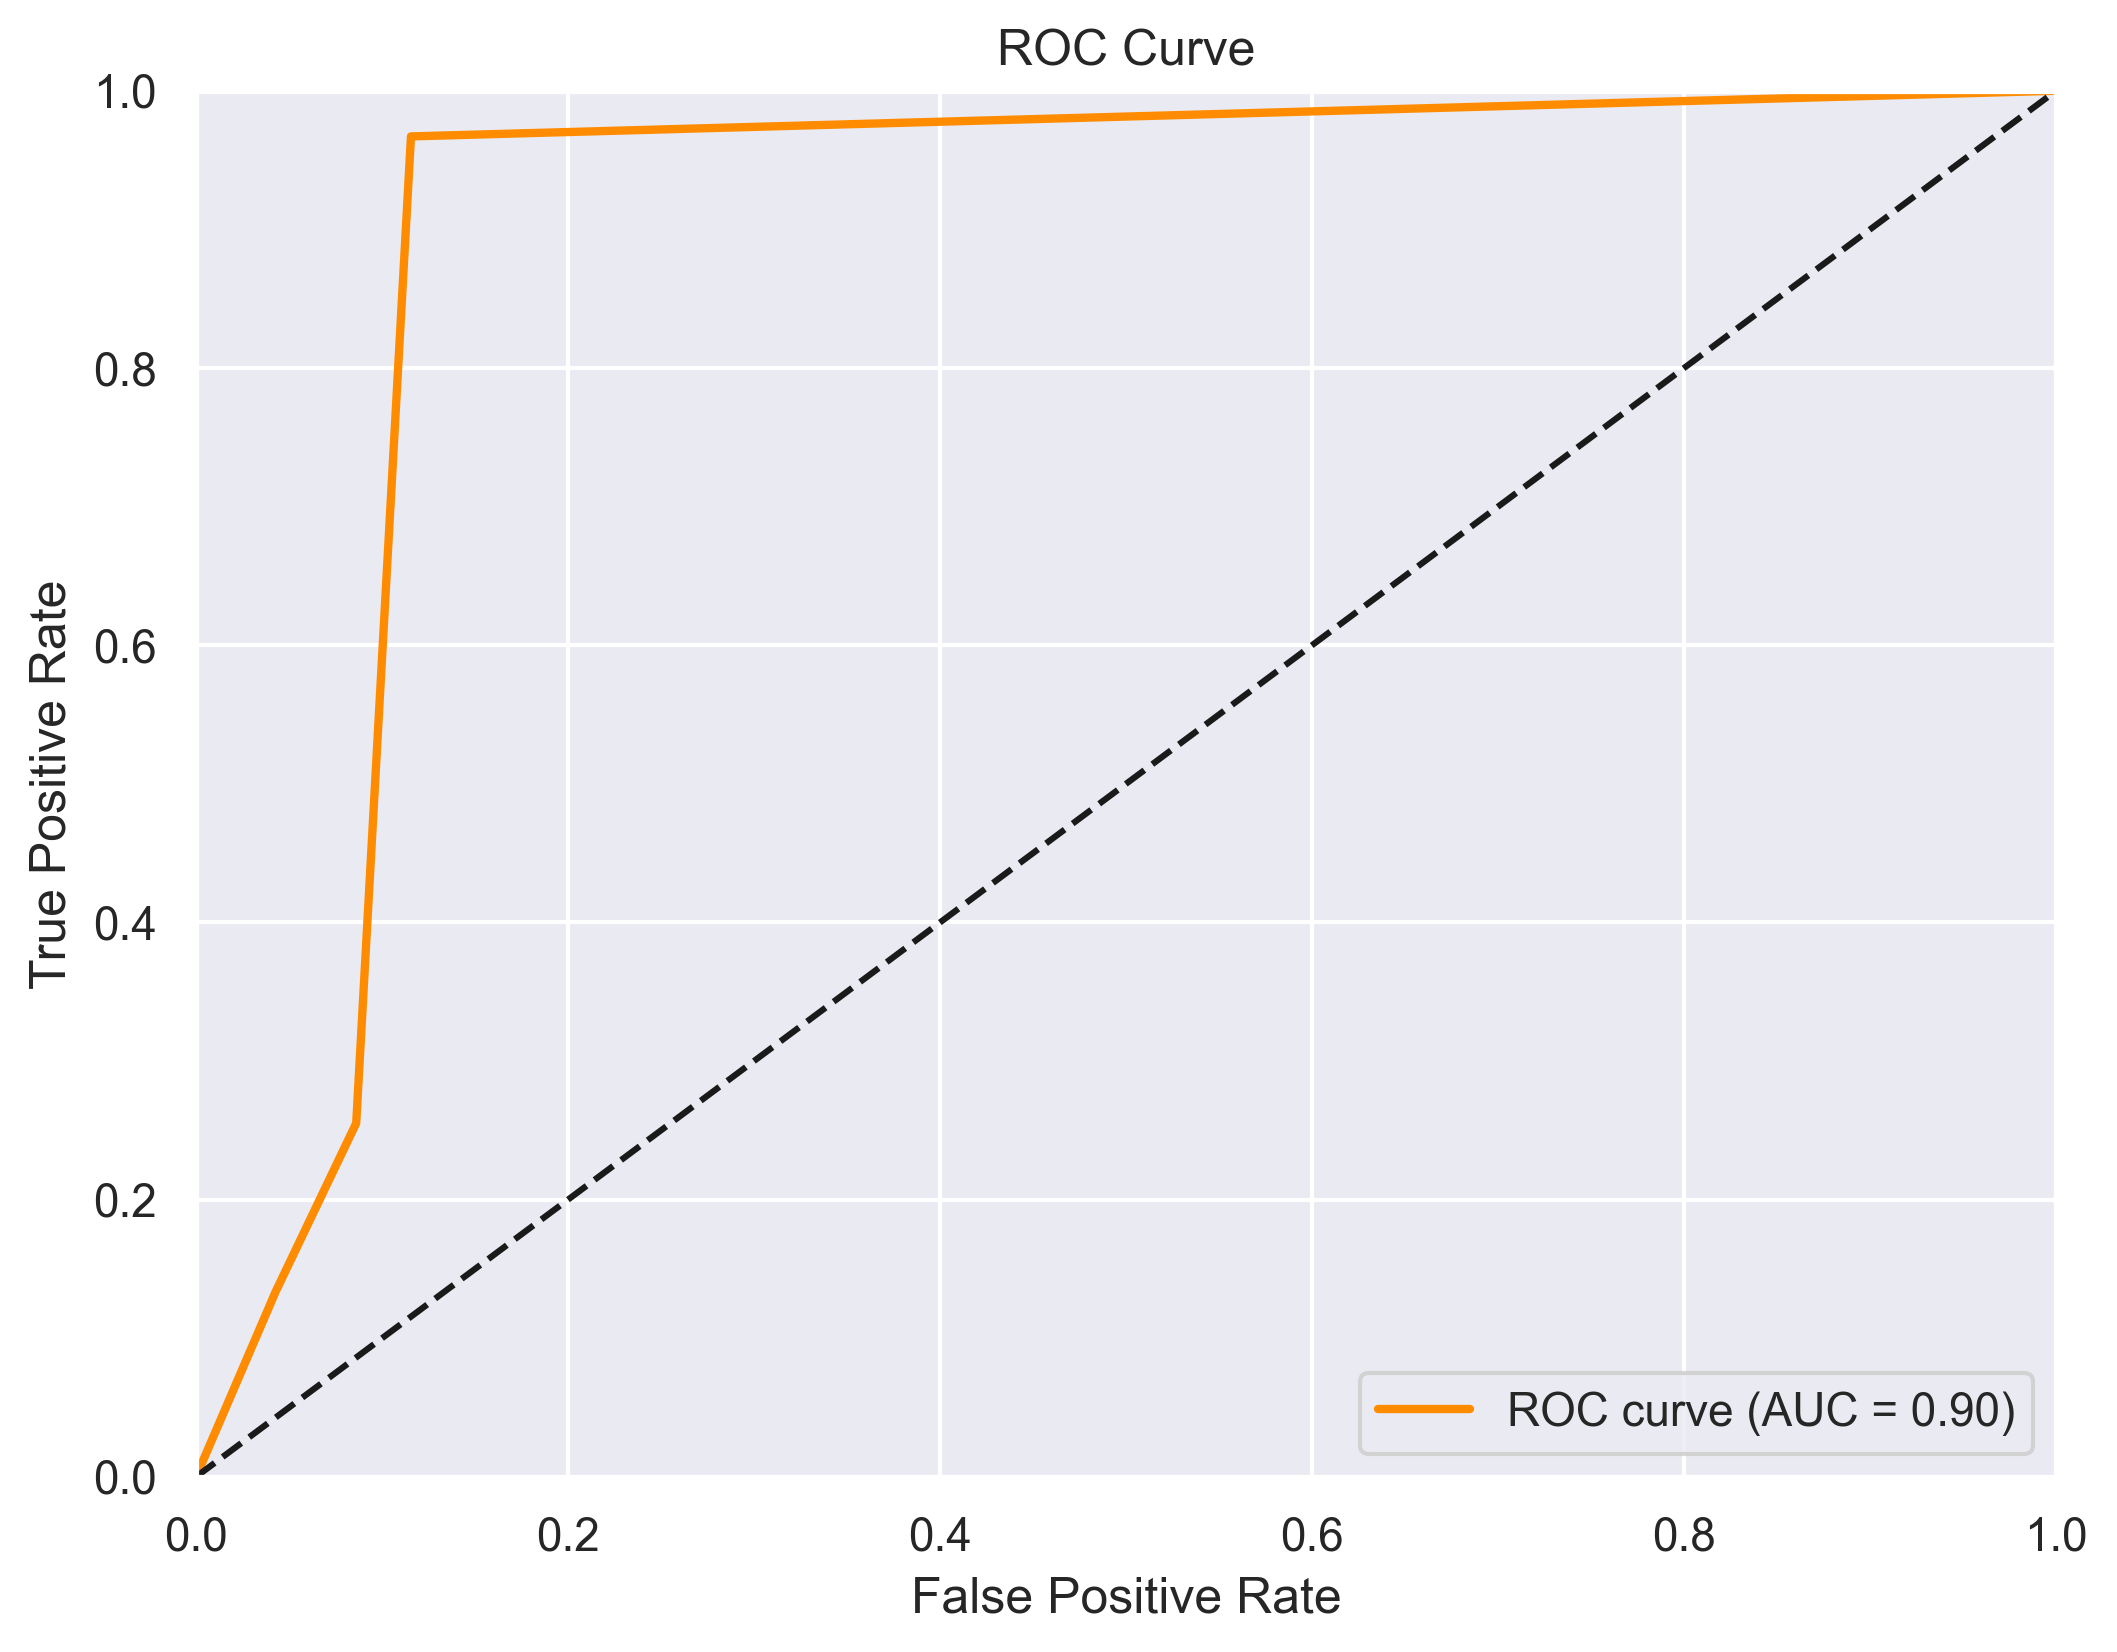

In [37]:
# ROC曲线&AUC值
fpr_voting, tpr_voting, thresholds = roc_curve(y_test, y_voting_pred, pos_label=1)
auc_voting = auc(fpr_voting, tpr_voting)

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr_voting, tpr_voting, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_voting)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
fname="Voting_ROC曲线.png"

### 2.13 Native Bayes

最佳参数: {'var_smoothing': 1e-07}
最佳得分: 0.3810955439451772
预测准确率: 0.8058141503046716


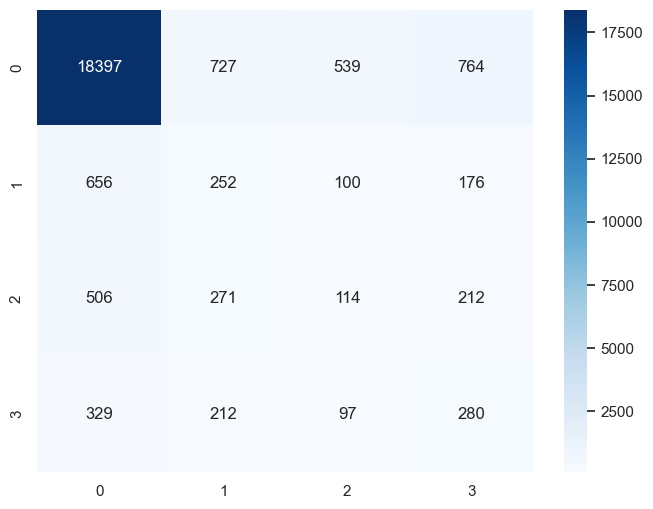

In [38]:
## 13、Native Bayes
## 调参
# 定义参数网格
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# 网格搜索
grid_search = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=param_grid,
    cv=5,  # 5 折交叉验证
    scoring='accuracy',
    return_train_score=True,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)
print("最佳参数:", grid_search.best_params_)
print("最佳得分:", grid_search.best_score_)

# 最优模型拟合
nb_basic = grid_search.best_estimator_
nb_basic.fit(X_train, y_train)

# 模型预测
y_preds = nb_basic.predict(X_test)
accuracy, cnf_matrix = model_eval(nb_basic, X_test, y_test)
print("预测准确率:", accuracy)

# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="Native Bayes混淆矩阵.png")

In [39]:
temp = store_results("Native Bayes", y_train, X_train, y_test, X_test, nb_basic, 5)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.864379,NaN,0.000000,0.864379,NaN,0.000000,0.249995,0.249993,0.249993,0.249993,0.249993,0.250000
1,logistic,0.786814,0.195408,0.556000,0.786814,0.195408,0.556000,0.443812,0.446013,0.444763,0.444711,0.440334,0.443237
2,决策树,0.826803,0.402211,0.947883,0.826803,0.402211,0.947883,0.632653,0.633306,0.634192,0.627602,0.632134,0.636032
3,KNN,0.803487,0.342152,0.754130,0.803487,0.342152,0.754130,0.903248,0.903045,0.902081,0.901013,0.904348,0.905752
4,XGBoost,0.895227,0.506841,0.955451,0.895227,0.506841,0.955451,0.788193,0.790252,0.789653,0.783323,0.791086,0.786652
5,LightGBM,0.948037,0.845697,0.954241,0.948037,0.845697,0.954241,0.917262,0.912084,0.920915,0.916747,0.917294,0.919272
6,Bagging,0.954172,0.904255,0.959368,0.954172,0.904255,0.959368,0.974758,0.970538,0.976061,0.975227,0.976113,0.975852
7,Random Forest,0.828707,0.284626,0.888112,0.828707,0.284626,0.888112,0.570427,0.571883,0.573055,0.570684,0.566464,0.570048
8,Stacking,0.934326,0.725779,0.953409,0.934326,0.725779,0.953409,0.870520,0.866264,0.871656,0.871343,0.871317,0.872017
9,Voting,0.934792,0.740478,0.954338,0.934792,0.740478,0.954338,0.871186,0.868530,0.873610,0.868139,0.872333,0.873320


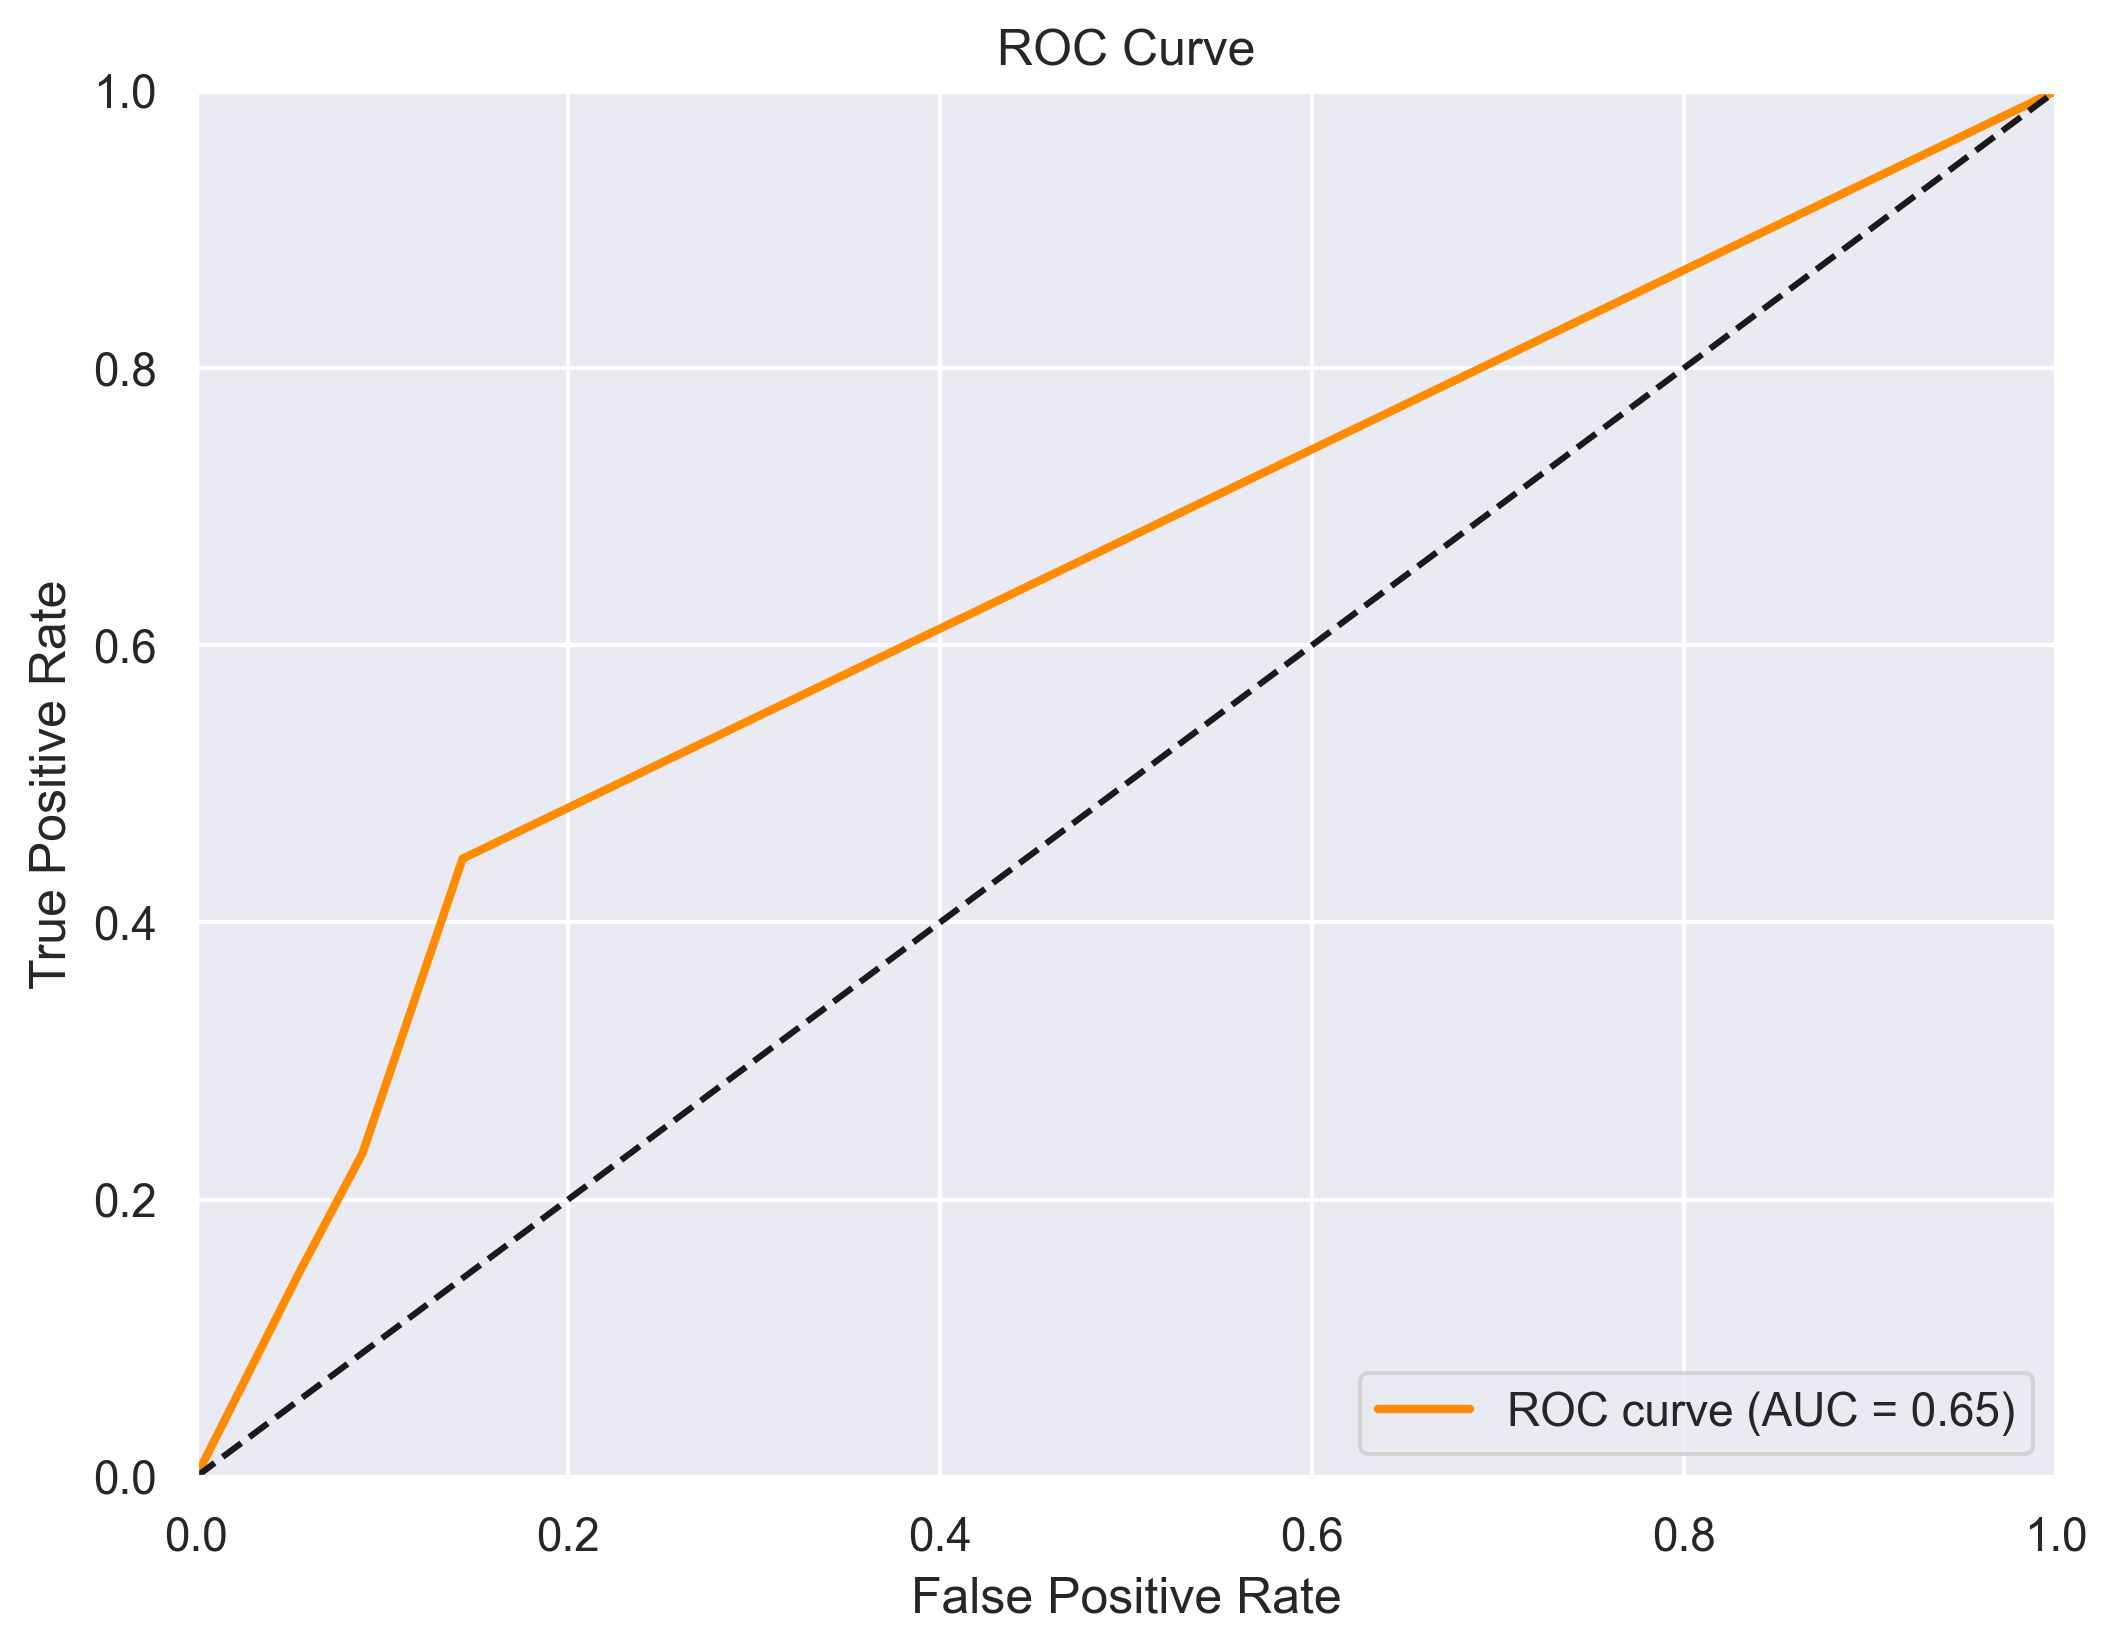

In [40]:
##  ROC曲线&AUC值
fpr_nb, tpr_nb, thresholds = roc_curve(y_test, y_preds, pos_label=1)
auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_nb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig(fname="Native Bayes_ROC曲线.png")

## 三、模型对比
##### ROC&AUC

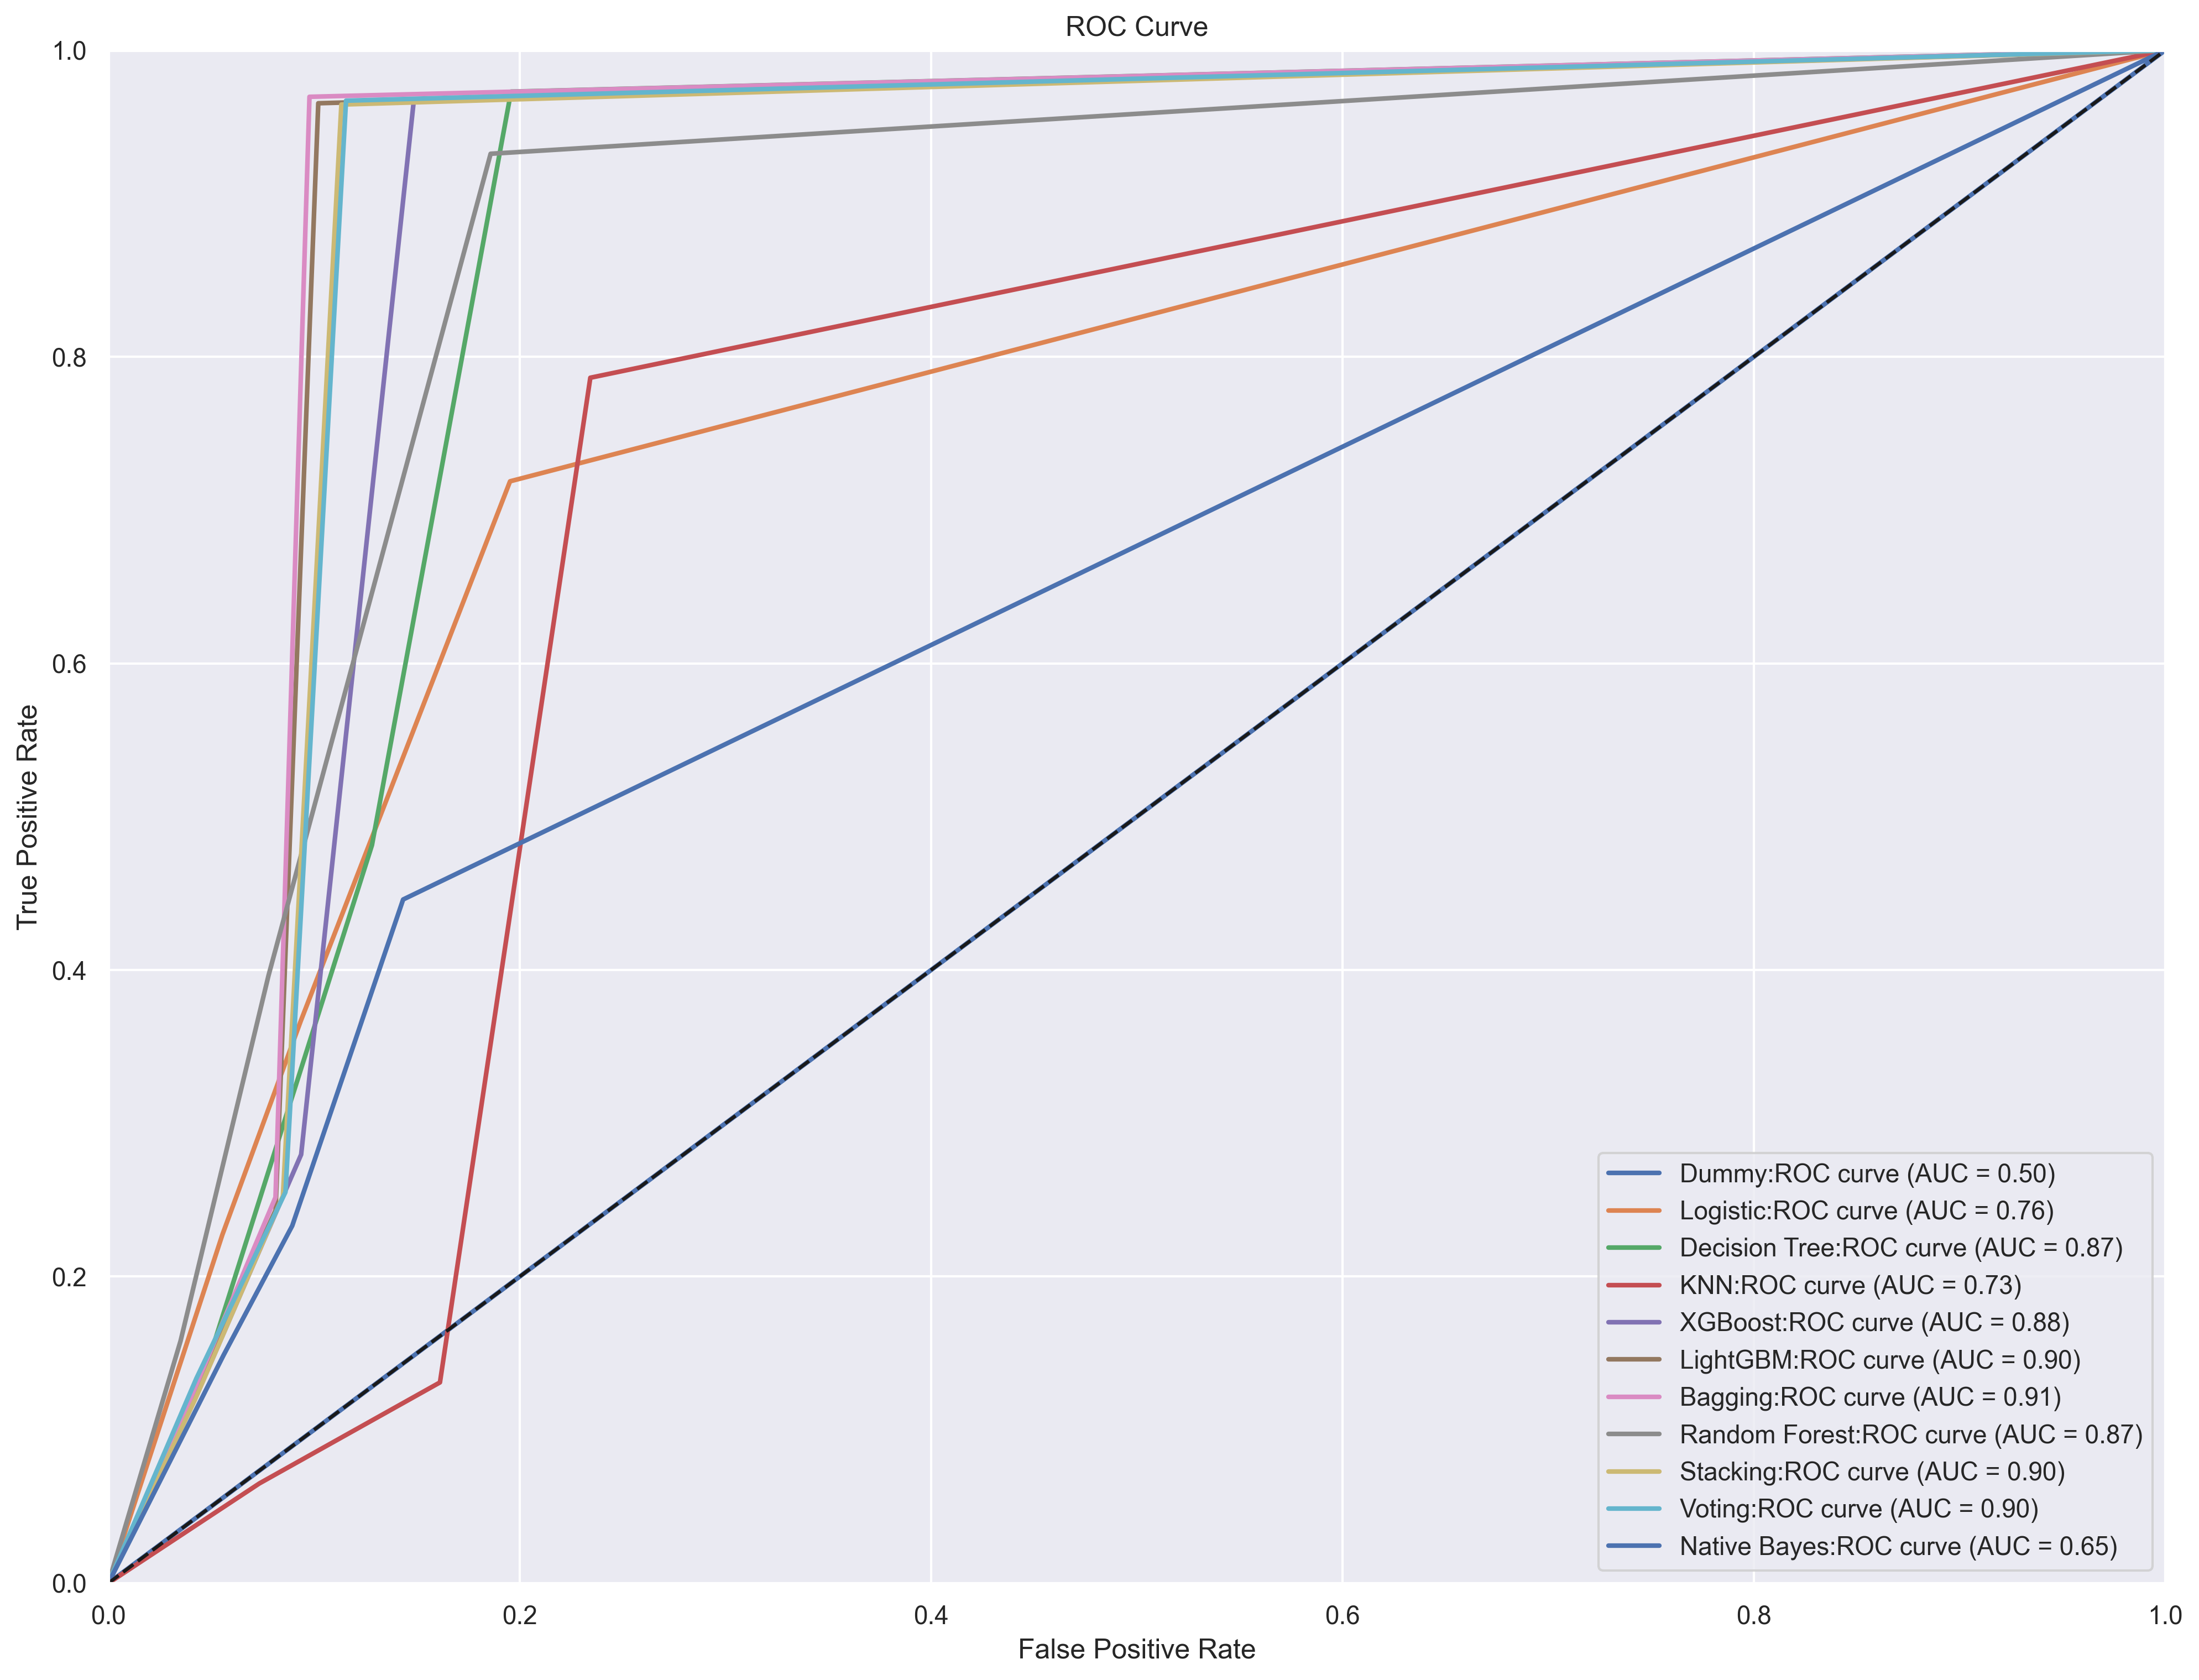

In [42]:
## 模型对比
plt.figure(figsize=(16, 12), dpi=300)
plt.plot(fpr_dummy, tpr_dummy, lw=2, label='Dummy:ROC curve (AUC = %0.2f)' % auc_dummy)
plt.plot(fpr_logistic, tpr_logistic, lw=2, label='Logistic:ROC curve (AUC = %0.2f)' % auc_logistic)
plt.plot(fpr_dt, tpr_dt, lw=2, label='Decision Tree:ROC curve (AUC = %0.2f)' % auc_dt)
plt.plot(fpr_knn, tpr_knn, lw=2, label='KNN:ROC curve (AUC = %0.2f)' % auc_knn)
plt.plot(fpr_xgb, tpr_xgb, lw=2, label='XGBoost:ROC curve (AUC = %0.2f)' % auc_xgb)
plt.plot(fpr_lgb, tpr_lgb, lw=2, label='LightGBM:ROC curve (AUC = %0.2f)' % auc_lgb)
plt.plot(fpr_bag, tpr_bag, lw=2, label='Bagging:ROC curve (AUC = %0.2f)' % auc_bag)
plt.plot(fpr_rf, tpr_rf, lw=2, label='Random Forest:ROC curve (AUC = %0.2f)' % auc_rf)
plt.plot(fpr_stacking, tpr_stacking, lw=2, label='Stacking:ROC curve (AUC = %0.2f)' % auc_stacking)
plt.plot(fpr_voting, tpr_voting, lw=2, label='Voting:ROC curve (AUC = %0.2f)' % auc_voting)
plt.plot(fpr_nb, tpr_nb, lw=2, label='Native Bayes:ROC curve (AUC = %0.2f)' % auc_nb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig(fname="ROC曲线.png")

##### 混淆矩阵

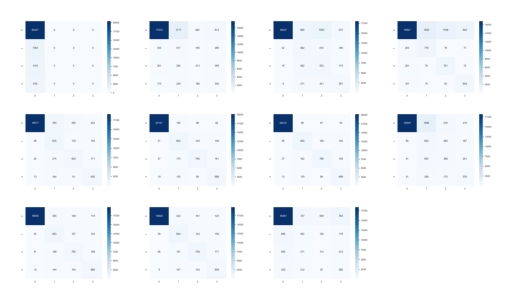

In [45]:
image_names = [
    'Dummy classifier混淆矩阵.png', 'Logistic混淆矩阵.png', '决策树混淆矩阵.png', 'KNN混淆矩阵.png', 
    'XGBoost混淆矩阵.png', 'LightGBM混淆矩阵.png', 'Bagging混淆矩阵.png', 
    'Random Forest混淆矩阵.png', 'Stacking混淆矩阵.png', 'Voting混淆矩阵.png', 'Native Bayes混淆矩阵.png'
]

# 打开所有图片
images = [Image.open(name) for name in image_names]

# 获取所有图片中最大的宽度和高度
max_width = max([img.width for img in images])
max_height = max([img.height for img in images])

# 创建一个新的空白图像，用于拼接
new_image = Image.new('RGB', (4 * max_width, 3 * max_height), (255, 255, 255))

# 遍历图片列表，将图片粘贴到新图像上
for i, img in enumerate(images):
    x = (i % 4) * max_width
    y = (i // 4) * max_height
    new_image.paste(img, (x, y))

# 保存拼接后的图片
new_image.save("混淆矩阵.png")

# 显示拼接后的图片（可选）
plt.imshow(np.array(new_image))
plt.axis('off')
plt.show()